In [1]:
import warnings
warnings.filterwarnings('ignore')

# Import libraries 

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pingouin

In [3]:
from statsmodels.stats.proportion import proportion_confint
from scipy.stats import t
from scipy.stats import chi2

from scipy.stats import levene
from scipy.stats import ttest_ind
from scipy.stats import mannwhitneyu
from scipy.stats import ttest_ind
from scipy.stats import f_oneway
from scipy.stats import chi2_contingency

In [4]:
import sys
import os
sys.path.append(os.path.abspath('../src'))

from stats_utils import *

# Import Data

In [5]:
from sklearn.datasets import load_diabetes

diabetes = load_diabetes()

In [6]:
data = pd.read_csv('../data/raw/4_stat_ncsu_edu_diabetes_tab', sep='\t')

In [7]:
data

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,2,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,2,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,2,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,1,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


# Data Exploration

## Overview

In [8]:
# Overview
print("data size: ", data.shape)
data.info()

data size:  (442, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 11 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AGE     442 non-null    int64  
 1   SEX     442 non-null    int64  
 2   BMI     442 non-null    float64
 3   BP      442 non-null    float64
 4   S1      442 non-null    int64  
 5   S2      442 non-null    float64
 6   S3      442 non-null    float64
 7   S4      442 non-null    float64
 8   S5      442 non-null    float64
 9   S6      442 non-null    int64  
 10  Y       442 non-null    int64  
dtypes: float64(6), int64(5)
memory usage: 38.1 KB


- the dataset contains no null values. That's a good point !
- The 'sex' is expressed as an _int_ -> This column will be transformed into binary.

In [9]:
# Any duplicates ? 
print(data.duplicated().sum())

0


In [10]:
# Descriptive statistical distributions
data.describe().round(2)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
count,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00,442.00
mean,48.52,1.47,26.38,94.65,189.14,115.44,49.79,4.07,4.64,91.26,152.13
std,13.11,0.50,4.42,13.83,34.61,30.41,12.93,1.29,0.52,11.50,77.09
min,19.00,1.00,18.00,62.00,97.00,41.60,22.00,2.00,3.26,58.00,25.00
25%,38.25,1.00,23.20,84.00,164.25,96.05,40.25,3.00,4.28,83.25,87.00
50%,50.00,1.00,25.70,93.00,186.00,113.00,48.00,4.00,4.62,91.00,140.50
75%,59.00,2.00,29.28,105.00,209.75,134.50,57.75,5.00,5.00,98.00,211.50
max,79.00,2.00,42.20,133.00,301.00,242.40,99.00,9.09,6.11,124.00,346.00


- At first glance, the distribution does not appear to contain any “obvious” outliers. 

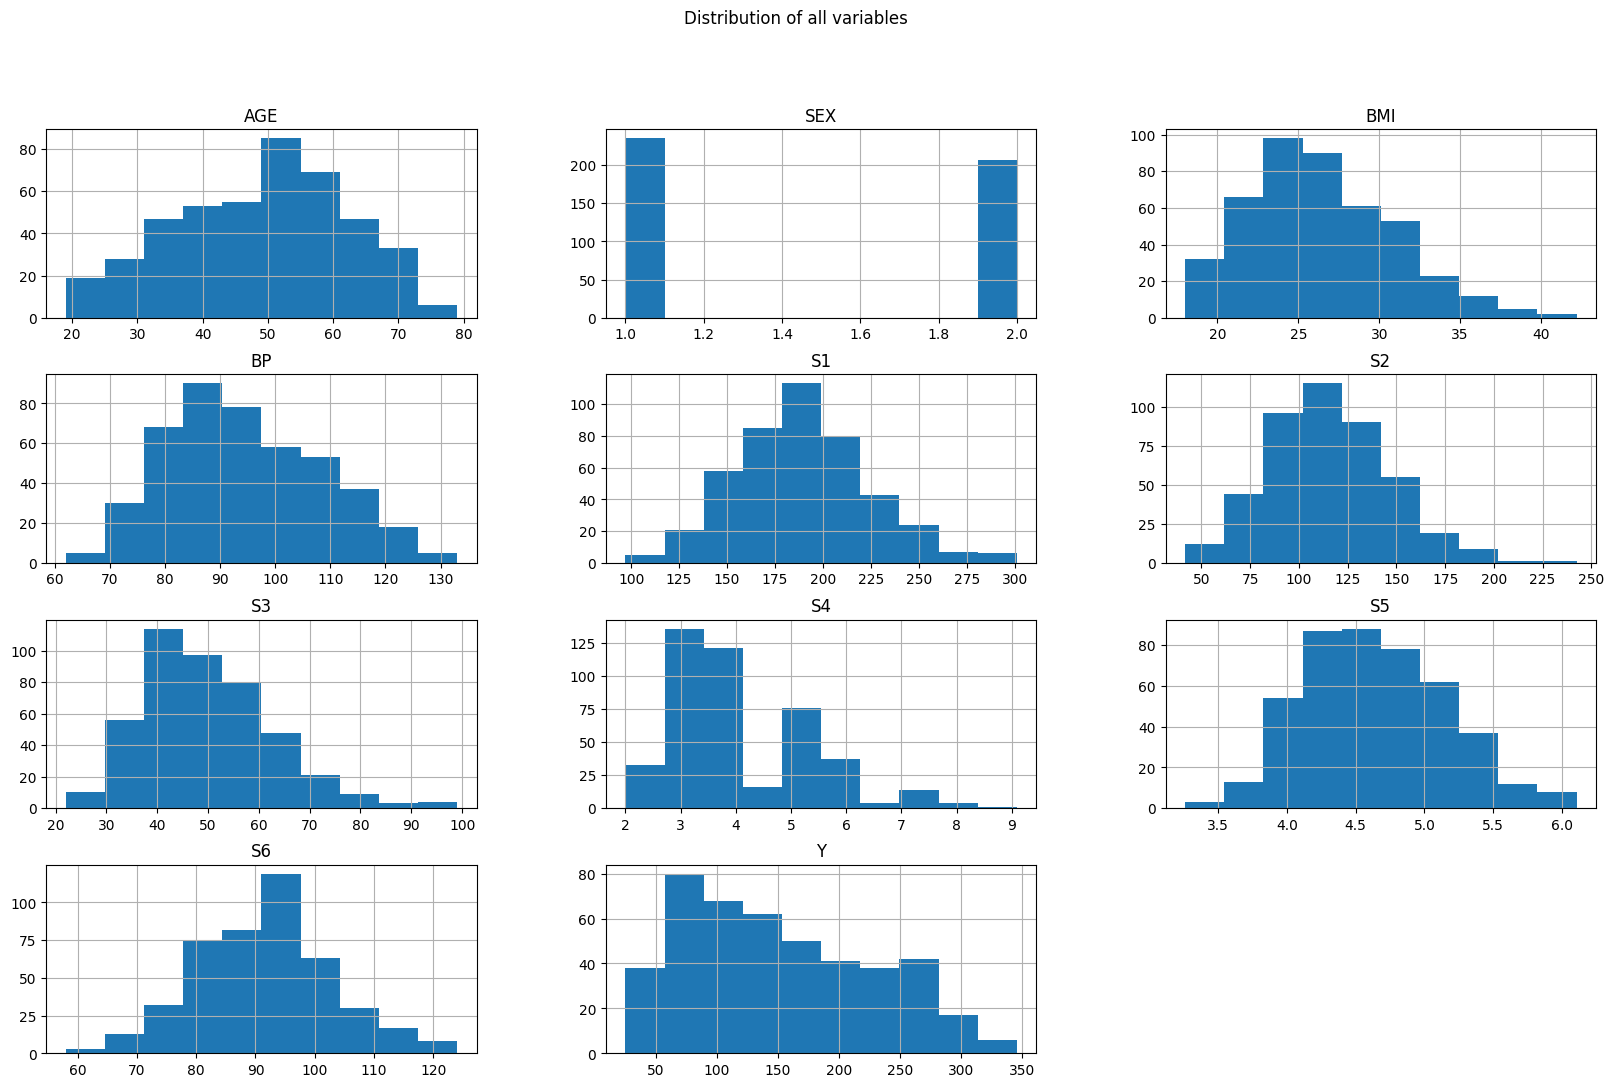

In [11]:
# Let's take a look at the distributions
data.hist(figsize=(20,12))
plt.suptitle("Distribution of all variables")
plt.show()

- As mentioned above, there are no “obvious” outliers, but the S2 and S3 variables may have some. 
- Most variables appear to be normally distributed, allowing us to apply certain tests (after checking).

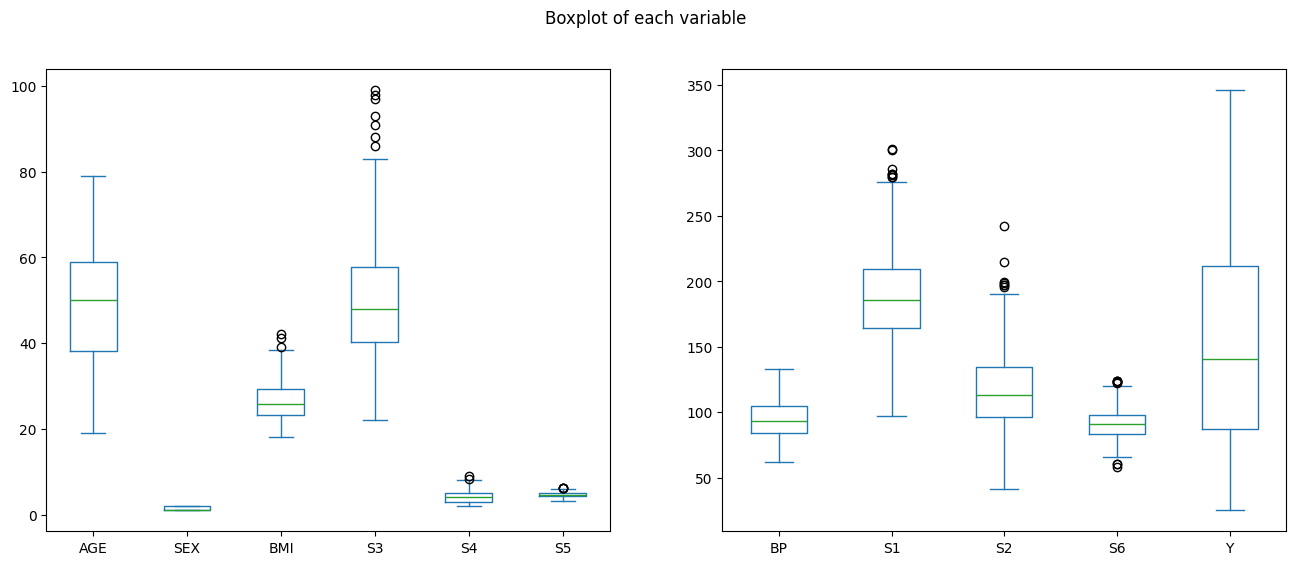

In [12]:
# Let's naively check the outliers boxplot/IQR 

# We will display 2 plots, in order to have a better visualization on the small scale variables
low_scale_var = [i for i in data.columns if data[i].max() < 100]
large_scale_var = [i for i in data.columns if i not in low_scale_var]

# Plot the graph
fig, axes = plt.subplots(1,2, figsize=(16,6))
data[low_scale_var].plot(kind='box', ax=axes[0])
data[large_scale_var].plot(kind='box', ax=axes[1])
plt.suptitle("Boxplot of each variable")
plt.show()

In [13]:
# Check outliers with z-score 
from scipy.stats import zscore 
data_zscore = pd.DataFrame(zscore(data), columns=data.columns)
print("Number of outliers by columns: ") 
print((np.abs(data_zscore) > 3).sum())

Number of outliers by columns: 
AGE    0
SEX    0
BMI    2
BP     0
S1     2
S2     2
S3     5
S4     4
S5     0
S6     0
Y      0
dtype: int64


In [14]:
# Index of the line with outliers 
zscore_outlier_index = np.where(np.abs(data_zscore) > 3)[0]
zscore_outlier_index

array([ 58, 123, 123, 123, 216, 230, 230, 256, 260, 261, 269, 322, 336,
       367, 441])

In [15]:
data.iloc[zscore_outlier_index,:]

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
58,60,1,20.4,105.00,198,78.4,99.0,2.00,4.6347,79,170
123,50,2,29.6,94.33,300,242.4,33.0,9.09,4.8122,109,84
123,50,2,29.6,94.33,300,242.4,33.0,9.09,4.8122,109,84
123,50,2,29.6,94.33,300,242.4,33.0,9.09,4.8122,109,84
216,52,2,29.7,109.00,228,162.8,31.0,8.00,5.1417,103,248
230,38,2,33.0,78.00,301,215.0,50.0,6.02,5.1930,108,220
230,38,2,33.0,78.00,301,215.0,50.0,6.02,5.1930,108,220
256,35,1,41.3,81.00,168,102.8,37.0,5.00,4.9488,94,346
260,60,1,25.6,78.00,195,95.4,91.0,2.00,3.7612,87,39
261,62,1,22.5,125.00,215,99.0,98.0,2.00,4.4998,95,103


In [16]:
(np.abs(data_zscore) > 3).iloc[zscore_outlier_index,:]

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
58,False,False,False,False,False,False,True,False,False,False,False
123,False,False,False,False,True,True,False,True,False,False,False
123,False,False,False,False,True,True,False,True,False,False,False
123,False,False,False,False,True,True,False,True,False,False,False
216,False,False,False,False,False,False,False,True,False,False,False
230,False,False,False,False,True,True,False,False,False,False,False
230,False,False,False,False,True,True,False,False,False,False,False
256,False,False,True,False,False,False,False,False,False,False,False
260,False,False,False,False,False,False,True,False,False,False,False
261,False,False,False,False,False,False,True,False,False,False,False


- **NB:**  
Here, we consider that these are true data and that outliers are certainly due to poor recording.
- For example, if s1 was = 2000 instead of s1=200. 
As this is not the case here, we will not remove data considered as outliers in the sense of the interquartile range.
- But this first exploration of the outliers will serve us later in the analysis

## Data Cleaning
**Renaming & formating**  

In [17]:
# Create the dataframe of analysis 
df = data.copy(deep=True)

In [18]:
# Display information about the dataset, sush as name
diabetes.keys()

dict_keys(['data', 'target', 'frame', 'DESCR', 'feature_names', 'data_filename', 'target_filename', 'data_module'])

In [19]:
diabetes['DESCR']

'.. _diabetes_dataset:\n\nDiabetes dataset\n----------------\n\nTen baseline variables, age, sex, body mass index, average blood\npressure, and six blood serum measurements were obtained for each of n =\n442 diabetes patients, as well as the response of interest, a\nquantitative measure of disease progression one year after baseline.\n\n**Data Set Characteristics:**\n\n:Number of Instances: 442\n\n:Number of Attributes: First 10 columns are numeric predictive values\n\n:Target: Column 11 is a quantitative measure of disease progression one year after baseline\n\n:Attribute Information:\n    - age     age in years\n    - sex\n    - bmi     body mass index\n    - bp      average blood pressure\n    - s1      tc, total serum cholesterol\n    - s2      ldl, low-density lipoproteins\n    - s3      hdl, high-density lipoproteins\n    - s4      tch, total cholesterol / HDL\n    - s5      ltg, possibly log of serum triglycerides level\n    - s6      glu, blood sugar level\n\nNote: Each of thes

In [20]:
# Rename each variable 
column_name_dict = {
    'AGE': 'age',
    'SEX': 'sex',
    'BMI': 'bmi', # body mass index
    'BP': 'bp',  # average blood pressure
    'S1': 'tc', # total serum cholesterol
    'S2': 'ldl', #low-density lipoproteins, 
    'S3': 'hdl', #high-density lipoproteins, 
    'S4': 'tch', #total cholesterol / HDL, 
    'S5': 'ltg', #possibly log of serum triglycerides level, 
    'S6': 'glu', #blood sugar level, 
    'Y': 'y' #the response of interest, a quantitative measure of disease progression one year after baseline.
}

df.rename(columns=column_name_dict, inplace = True)

In [21]:
# Create a dictionnary of the name of the variable 
column_name_long_form = ['age','sex','body_mass_index', 'average_blood_pressure', 'total_cholesterol', 'low_density_lipoproteins',
                         'high_density_lipoproteins', 'total_cholesterol/HDL', 'log_of_triglycerides_level', 'glucose', 'progression_y']
column_long_name = {k:v for (k,v) in zip(column_name_dict.values(), column_name_long_form)}
column_long_name

{'age': 'age',
 'sex': 'sex',
 'bmi': 'body_mass_index',
 'bp': 'average_blood_pressure',
 'tc': 'total_cholesterol',
 'ldl': 'low_density_lipoproteins',
 'hdl': 'high_density_lipoproteins',
 'tch': 'total_cholesterol/HDL',
 'ltg': 'log_of_triglycerides_level',
 'glu': 'glucose',
 'y': 'progression_y'}

In [22]:
# Transform the 'sex' column into binary
df['sex'] = df['sex'] - 1
df['sex'].value_counts(dropna=False)

sex
0    235
1    207
Name: count, dtype: int64

In [23]:
# Final df
df

,age,sex,bmi,bp,tc,ldl,hdl,tch,ltg,glu,y
0,59,1,32.1,101.00,157,93.2,38.0,4.00,4.8598,87,151
1,48,0,21.6,87.00,183,103.2,70.0,3.00,3.8918,69,75
2,72,1,30.5,93.00,156,93.6,41.0,4.00,4.6728,85,141
3,24,0,25.3,84.00,198,131.4,40.0,5.00,4.8903,89,206
4,50,0,23.0,101.00,192,125.4,52.0,4.00,4.2905,80,135
...,...,...,...,...,...,...,...,...,...,...,...
437,60,1,28.2,112.00,185,113.8,42.0,4.00,4.9836,93,178
438,47,1,24.9,75.00,225,166.0,42.0,5.00,4.4427,102,104
439,60,1,24.9,99.67,162,106.6,43.0,3.77,4.1271,95,132
440,36,0,30.0,95.00,201,125.2,42.0,4.79,5.1299,85,220


## Documentation of clinical indicators 

Before any exploratory analysis or modeling, I thought it was essential to understand precisely the meaning of each variable in the dataset, as well as its role and potential impact on health. This section summarizes the documentation carried out on each parameter in order to better contextualize the statistical analysis to come.

**About diabetes**  
Diabetes is a chronic disease that affects the way the body uses glucose (blood sugar). Insulin, a hormone produced by the pancreas, helps regulate blood sugar levels. With diabetes, this regulation is disrupted, leading to an increase in blood sugar levels. Several factors influence the development of diabetes.

#### Description of variables and their influence on diabetes

**Factors and their influence on diabetes :**

1. **Age**
    - With age, metabolism slows down and insulin sensitivity decreases.
    - The risk of type 2 diabetes increases with age.
2. **Gender**
    - Hormonal differences between men and women can influence glucose management.
    - Women who have had gestational diabetes have an increased risk of developing type
3. **BMI (Body Mass Index)**
    - Obesity is a major risk factor for type 2 diabetes.
    - Excess abdominal fat is particularly associated with insulin resistance.
5. **BP (Mean Blood Pressure)**
    - Hypertension is often associated with diabetes, as it reflects overall metabolic dysfunction.
    - It favors cardiovascular complications, aggravated by poor glucose control.
6. **S1 - TC Total serum cholesterol**
    - Elevated total serum cholesterol may indicate an increased risk of cardiovascular disease.
    - Diabetes can cause altered lipid metabolism, leading to imbalances in cholesterol levels.
7. **S2 - LDL (Low Density Lipoproteins)**
    - LDL is often referred to as “bad cholesterol”.
    - High levels promote the build-up of plaque in the arteries, increasing cardiovascular risk.
8. **S3 - HDL (High Density Lipoproteins)**
    - HDL is the “good cholesterol”, helping to eliminate excess cholesterol.
    - Low HDL levels are often observed in diabetics and increase the risk of complications.
9. **S4 - TCH (Total Cholesterol / HDL Ratio)**
    - A high ratio indicates an imbalance between good and bad cholesterol.
    - It is an indicator of increased cardiovascular risk.
10. **S5 - LTG (Log Serum Triglyceride Level)**
    - Triglycerides are fats circulating in the blood.
    - High levels are often associated with obesity, diabetes and high cardiovascular risk.
11. **S6 - GLU (Glucose - Blood Sugar Level)** 
    - This is the main indicator of diabetes.
    - A high level can indicate poor glucose regulation and insulin resistance.

## Data Analysis & Descriptive statistics

In [24]:
# nb of patient
n_sample = df.shape[0]
n_sample

442

### Analysis of the Progression: Y
Y is our target variable

In [25]:
# Calculate Manually the descriptive variable
print("Progression Y statistique: ")

# Min and max
y_min = df['y'].min()
y_max = df['y'].max()
print(f"- min: {y_min:.2f}")
print(f"- max: {y_max:.2f}")

# Mean
y_mean = (1/n_sample)*np.sum(df['y'])
print(f"- mean: {y_mean:.2f}")

# Median 
x_i = int((n_sample)/2)        #the x_(n/2) th element 
x_j = int((n_sample)/2) + 1    #the x_(n/2 + 1) th element 
y_median = ((np.sort(df['y'])[x_i-1] + np.sort(df['y'])[x_j-1])/2)  # -1 because the array start at 0
print(f"- median: {y_median:.2f}")

# variance 
y_var = (1/(n_sample)) * np.sum((df['y'] - y_mean)**2)
print(f"- variance: {y_var:.2f}")

#standard deviaion
y_std = np.sqrt(y_var)
print(f"- standard deviation: {y_std:.2f}")

print(f"The progression of our patients evolve from {y_min:.1f} à {y_max:.1f} with a average progression of {y_mean:.1f} and standard deviation of {y_std:.1f}")

Progression Y statistique: 
- min: 25.00
- max: 346.00
- mean: 152.13
- median: 140.50
- variance: 5929.88
- standard deviation: 77.01
The progression of our patients evolve from 25.0 à 346.0 with a average progression of 152.1 and standard deviation of 77.0


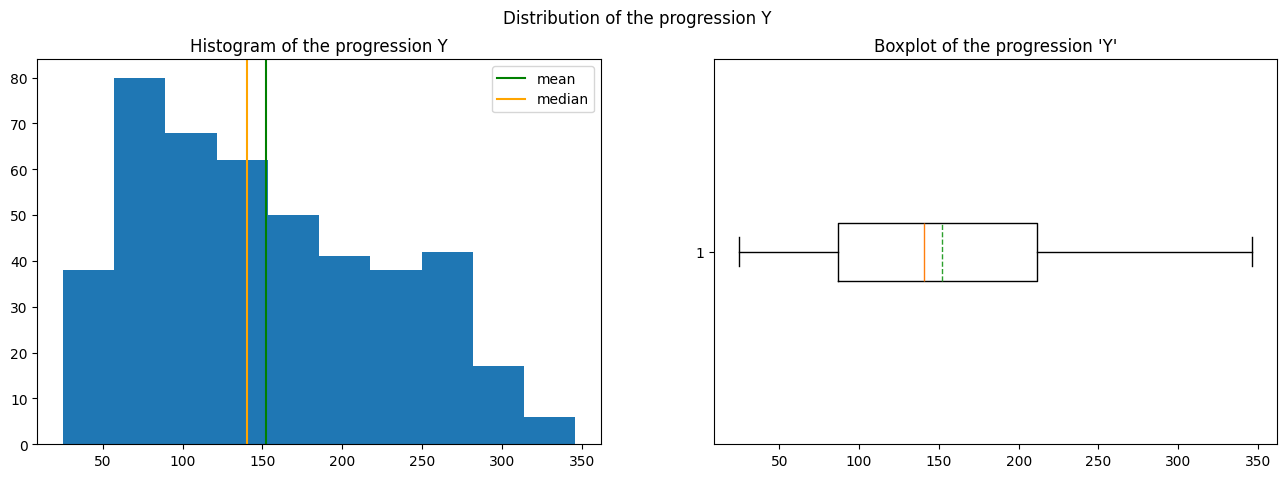

In [26]:
# Visualize the progression 
fig, ax = plt.subplots(1,2,figsize=(16,5))

# 1. Plot the distribution
ax[0].hist(df['y'])
ax[0].axvline(y_mean, color='green', label='mean')
ax[0].axvline(y_median, color='orange', linestyle = '-', label='median')
ax[0].legend()
ax[0].set_title("Histogram of the progression Y")

# 2. Plot the boxplot 
ax[1].boxplot(df['y'], orientation='horizontal', meanline=True, showmeans=True)
ax[1].set_title("Boxplot of the progression 'Y'")
fig.suptitle("Distribution of the progression Y")
plt.savefig("../images/11_eda_distribution_of_the_progression_y.png", dpi=300, bbox_inches='tight') #Save the image
plt.show()

In [27]:
# Calculate the skewness
y_skewness = df['y'].skew().item()
print(f"The distribution has a skewness of {y_skewness}")

The distribution has a skewness of 0.44056293407014124


- The distribution has a low skewness on the right

### Male/Female variable
- What is the repartition between male and femlale ?
- Is the distribution is equaly distributed?

In [28]:
# Proportion of man & woman
df['sex'].value_counts()
n_males = df['sex'].value_counts()[0]
proportion_males = n_males/n_sample

n_females = df['sex'].value_counts()[1]
proportion_females = n_females/n_sample

print(f"There are {n_males} men in the sample, ie {proportion_males:.2f}%")
print(f"There are {n_females} women in the sample, ie {proportion_females:.2f}%")

There are 235 men in the sample, ie 0.53%
There are 207 women in the sample, ie 0.47%


- The distribution seems to be equaly distributed. _But We will verify that with a test later in the study_

### Age analysis
1. What is the mean age of the patient ?

In [29]:
# Statistical distribution of age
df['age'].describe().round()

count    442.0
mean      49.0
std       13.0
min       19.0
25%       38.0
50%       50.0
75%       59.0
max       79.0
Name: age, dtype: float64

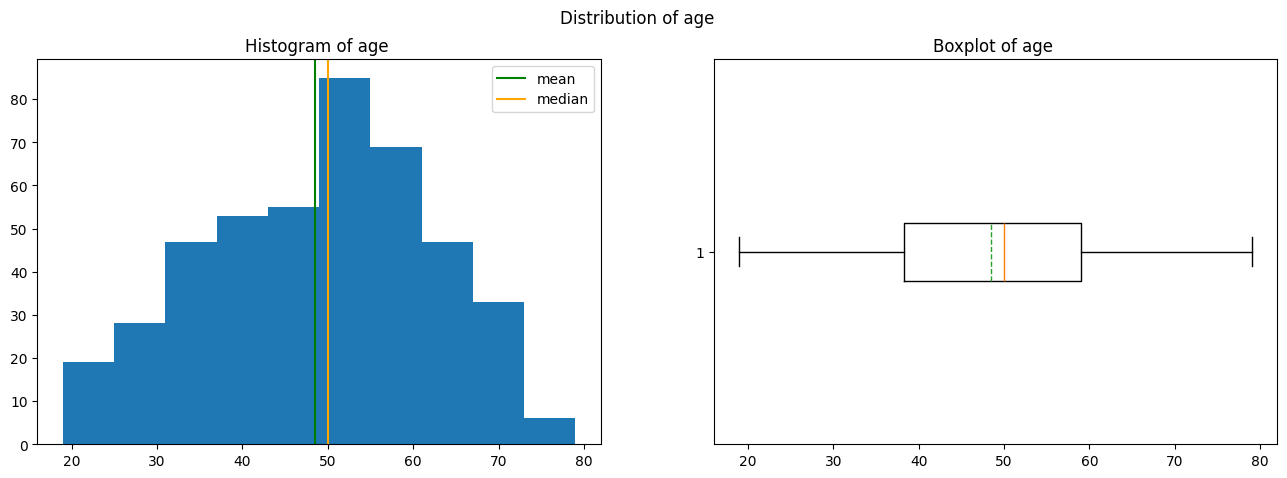

In [30]:
# Visualize the progression 
fig, ax = plt.subplots(1,2,figsize=(16,5))

# 1. Plot the distribution
ax[0].hist(df['age'])
ax[0].axvline(df['age'].mean(), color='green', label='mean')
ax[0].axvline(np.median(df['age']), color='orange', linestyle = '-', label='median')
ax[0].legend()
ax[0].set_title("Histogram of age ")
# 2. Plot the boxplot 
ax[1].boxplot(df['age'], orientation='horizontal', meanline=True, showmeans=True)
ax[1].set_title("Boxplot of age ")
fig.suptitle("Distribution of age")
plt.show()

- The age seems to be normal, with a mean at 49 year old and a standard deviation of 13 yo.

### BMI - Body Mass Index

In [31]:
# Calculate the descriptive statistics
bmi_min = df['bmi'].min()
bmi_max = df['bmi'].max()
bmi_mean = df['bmi'].mean()
bmi_median = np.median(df['bmi'])
bmi_var = np.var(df['bmi'], ddof=0)
bmi_std = np.std(df['bmi'], ddof=0)

print("BMI statistics: ")
print(f"- min: {bmi_min:.2f}")
print(f"- max: {bmi_max:.2f}")
print(f"- mean: {bmi_mean:.2f}")
print(f"- median: {bmi_median:.2f}")
print(f"- variance: {bmi_var:.2f}")
print(f"- standard deviation: {bmi_std:.2f}")
print(f"\n The bmi of the patients evolve from {bmi_min:.1f} à {bmi_max:.1f} \
with a average bmi of {bmi_mean:.1f} and standard deviation of {bmi_std:.1f}")

BMI statistics: 
- min: 18.00
- max: 42.20
- mean: 26.38
- median: 25.70
- variance: 19.48
- standard deviation: 4.41

 The bmi of the patients evolve from 18.0 à 42.2 with a average bmi of 26.4 and standard deviation of 4.4


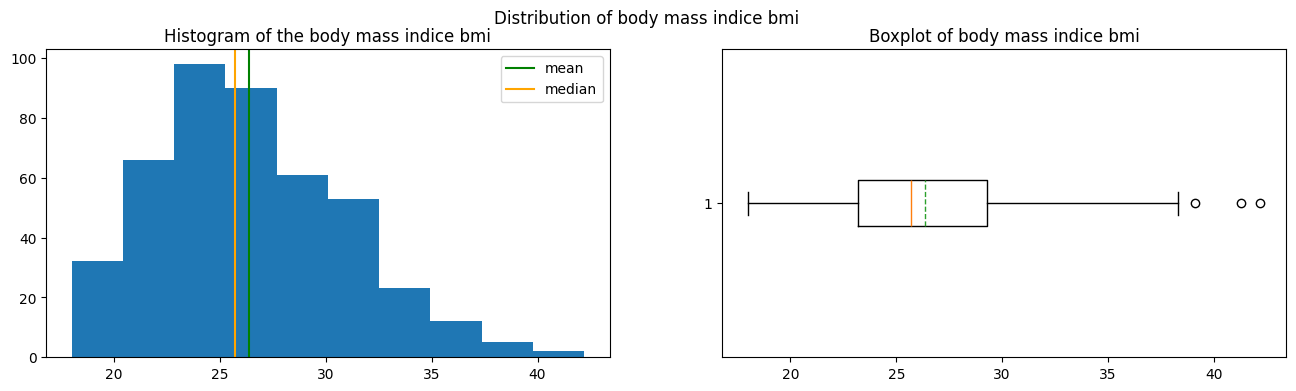

In [32]:
# Visualize the BMI
from stats_utils import display_distribution
display_distribution(df, 'bmi', 'body mass indice')

_**But what does that mean to have a mean around 26 ?**_

**BMI classification**  
|      Catégories      | IMC (kg/m2) |                       Risques de complications                       |
|:--------------------:|:-----------:|:--------------------------------------------------------------------:|
| Sous la normale      | < 18,5      | Faibles (mais plus grands risques pour d'autres problèmes cliniques) |
| Etendue normale      | 18,5 - 24,9 | Moyens                                                               |
| Surpoids             | 25,0 - 29,9 | Certains risques                                                     |
| Obèse                | > 30,0      |                                                                      |
| Classe I             | 30,0 - 34,9 | Modérés                                                              |
| Classe II - sévère   | 35,0 - 39,9 | Elevés                                                               |
| Classe III - morbide | > 40,0      | Très élevés                                                          |

_source: https://www.hug.ch/contrepoids/calcul-imc-chez-adulte_

- In average the patient of the sample are overweighted. But how many are really overweighted ?  
- And how many of them are considered as obese ? 

In [33]:
# Calculate the proportion of each class & create a new_variable
bmi_label = ['underweight','normal_weight','overweight','obese_class_1','obese_class_2','obese_class_3']
bmi_cut = [0,18.5, 25.0, 30.0, 35.0, 40, np.inf]
df['bmi_cat'] = pd.cut(df['bmi'], bmi_cut, right=False, labels = bmi_label)
df['bmi_cat'].value_counts(normalize=True, sort=False)

bmi_cat
underweight      0.004525
normal_weight    0.420814
overweight       0.350679
obese_class_1    0.180995
obese_class_2    0.038462
obese_class_3    0.004525
Name: proportion, dtype: float64

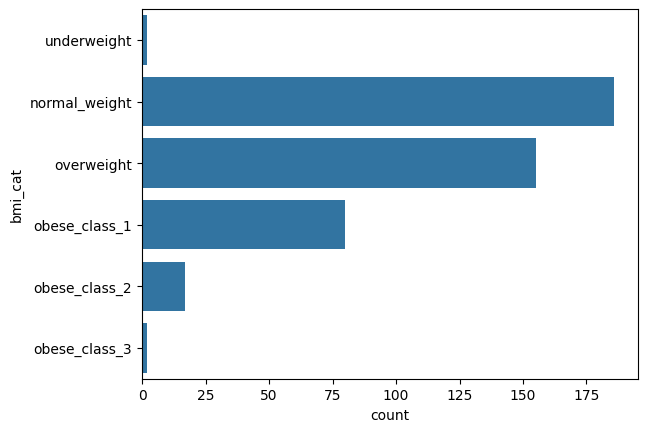

In [34]:
sns.countplot(df['bmi_cat'])
plt.show()

In [35]:
# Calculate the proportion of obese in the sample 
p_obese = sum(df['bmi']>30)/n_sample
p_obese
print(f"{p_obese*100:.2f}% of people in this sample are considered obese")

21.49% of people in this sample are considered obese


To conclude, we know most of the patient are overweighted, and the proportion of people with a bmi > 30 is  
$\hat{p}_{\text{bmi}>30} = 0.21 $

In [36]:
(df['bmi']>30).mean()

np.float64(0.2149321266968326)

### Bivariate analysis 
Now, we want to see the all variable according to the progression. And see if the sex have the impact  
- _NB: Further analysis will be conducted in the 'multivariate analysis' section before 'modeling'_

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 442 entries, 0 to 441
Data columns (total 12 columns):
 #   Column   Non-Null Count  Dtype   
---  ------   --------------  -----   
 0   age      442 non-null    int64   
 1   sex      442 non-null    int64   
 2   bmi      442 non-null    float64 
 3   bp       442 non-null    float64 
 4   tc       442 non-null    int64   
 5   ldl      442 non-null    float64 
 6   hdl      442 non-null    float64 
 7   tch      442 non-null    float64 
 8   ltg      442 non-null    float64 
 9   glu      442 non-null    int64   
 10  y        442 non-null    int64   
 11  bmi_cat  442 non-null    category
dtypes: category(1), float64(6), int64(5)
memory usage: 38.8 KB


**Corralation**

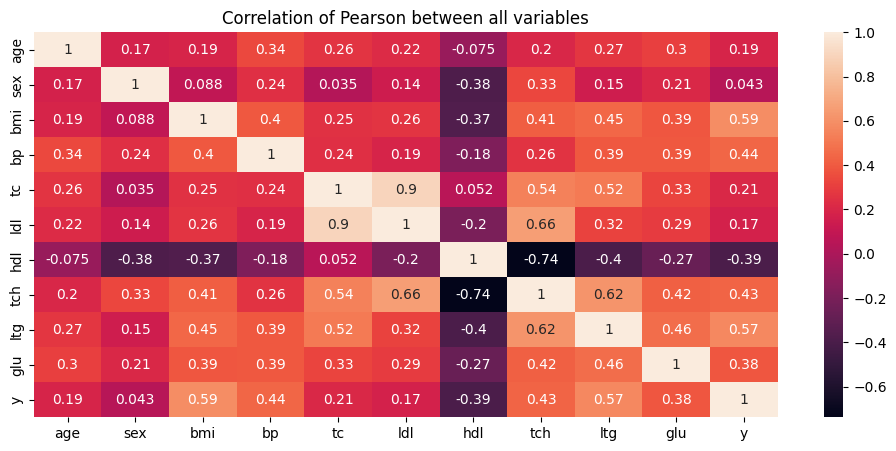

In [38]:
# Calculate the correlation of numerical variables
correlation = df.select_dtypes(include='number', exclude = 'category').corr()
plt.figure(figsize=(12,5))
sns.heatmap(correlation, annot=True)
plt.title("Correlation of Pearson between all variables")
plt.show()

- The strongest correlation couples are:
    - ldl ("bad" cholestérol) and the tc (total cholesterol) with r = 0.9
    - The tch (Ratio Cholestérol Total / HDL) with hdl (bon Cholestérol) r = -0.74
    - The tch with ldl r = 0.66  
- Variable don't have a strong linear correlation with the target variable y. The highest correlation is with bmi, and ltg.

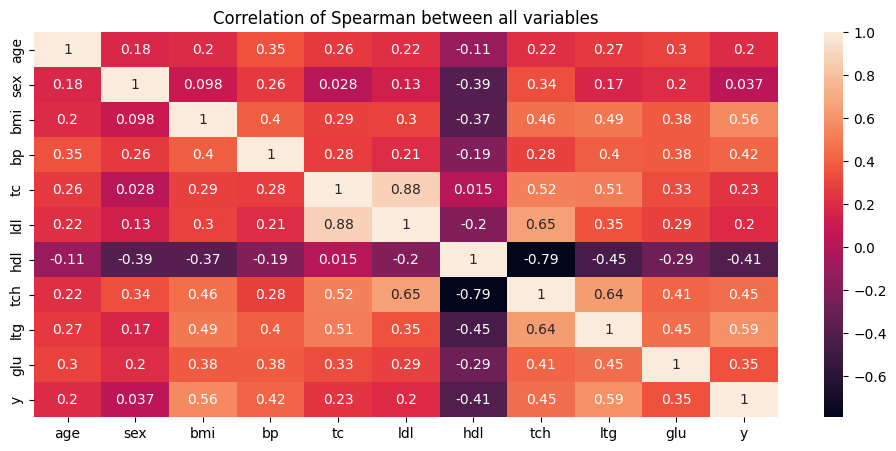

In [39]:
# Calculate the correlation of numerical variables
correlation = df.select_dtypes(include='number', exclude = 'category').corr(method='spearman')
plt.figure(figsize=(12,5))
sns.heatmap(correlation, annot=True)
plt.title("Correlation of Spearman between all variables")
plt.show()

**Progression 'Y' $ \times $ bmi**

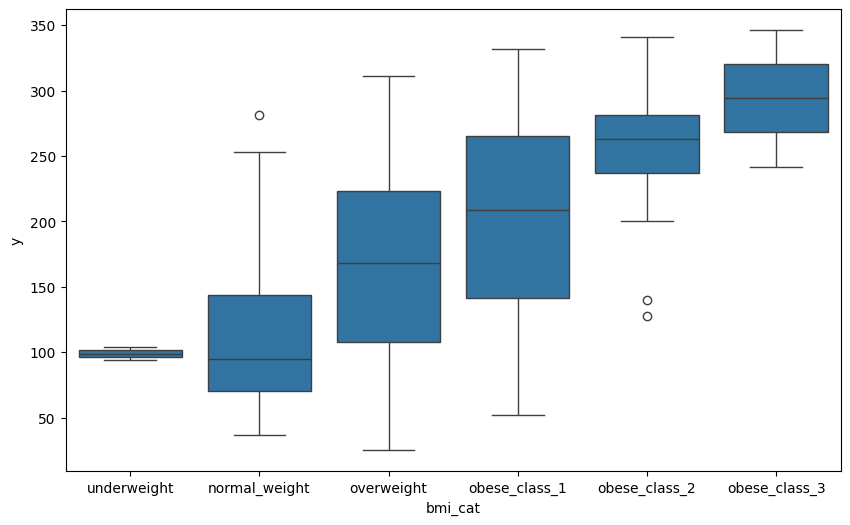

In [40]:
# Progression 'Y' bmi
# As we saw, the Y seem is more correlated to the bmi. We can visualized the distribution of the progression by bmi_categ
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x='bmi_cat', y='y')
plt.show()

- Overall, we can see that progression increases with bmi.

In [41]:
# Visualize the correlation of all variable with the progression
num_columns = df.select_dtypes(include='number', exclude = 'category').columns
explicative_variables = [i for i in num_columns if i !=  'y']

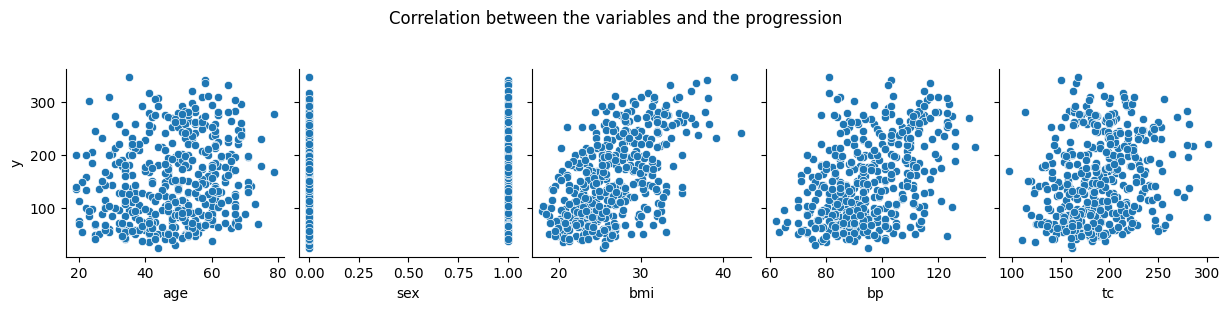

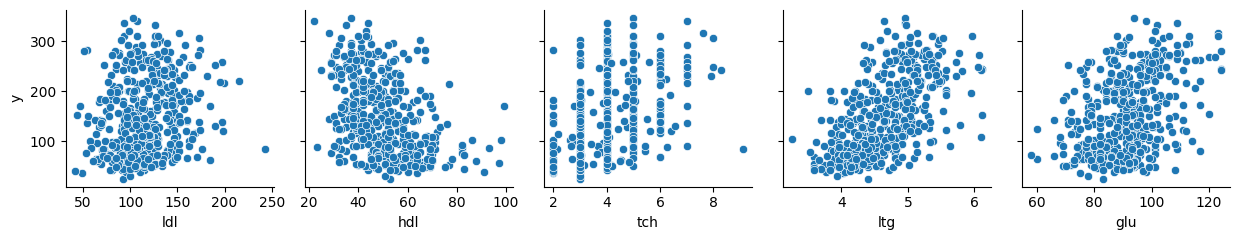

In [42]:
# Visualize the correlation of all variable with the progression
sns.pairplot(df[num_columns], x_vars=explicative_variables[0:5], y_vars='y')
plt.suptitle("Correlation between the variables and the progression", y=1.2)
sns.pairplot(df[num_columns], x_vars=explicative_variables[5:], y_vars='y')
plt.tight_layout()
plt.show()

- The scatterplots are consistent with the linear and non-linear correlations calculated. 
- I can't identify any “known” relationship between the response variable and the explanatory variables that could be used as a transformation in the modeling part (such as log, exp, etc.). 

Perhaps we'll distinguish patterns according to sex? 

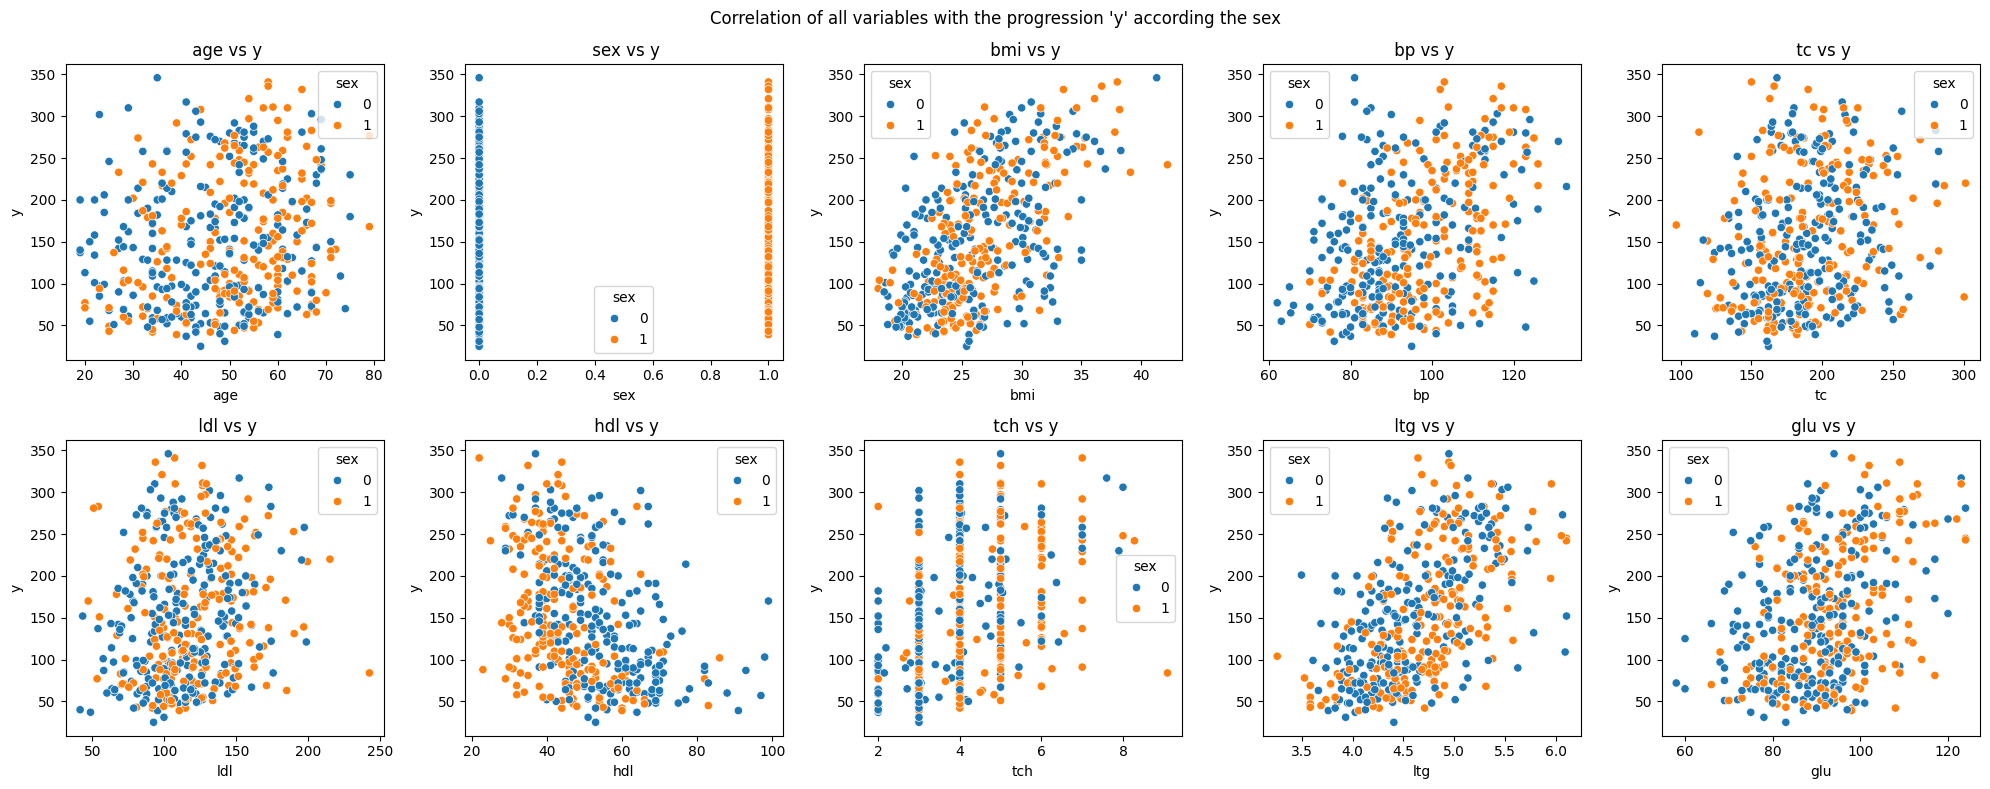

In [43]:
# Visualize the correlation of all variable with the progression according the sex variable
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))
axes = axes.flatten()

for idx, col in enumerate(df.select_dtypes(include='number').columns): 
    if col != 'y':
        sns.scatterplot(df, x=col, y='y', hue='sex', ax=axes[idx])
        axes[idx].set_title(f" {col} vs y")
plt.suptitle("Correlation of all variables with the progression 'y' according the sex")
plt.tight_layout()
plt.show()

- The 'sex' of the patients does not seem to affect the progression of the diabete y. 
- But it may have a impact the hdl and ltg. We can see that the hdl are lower for women than man.

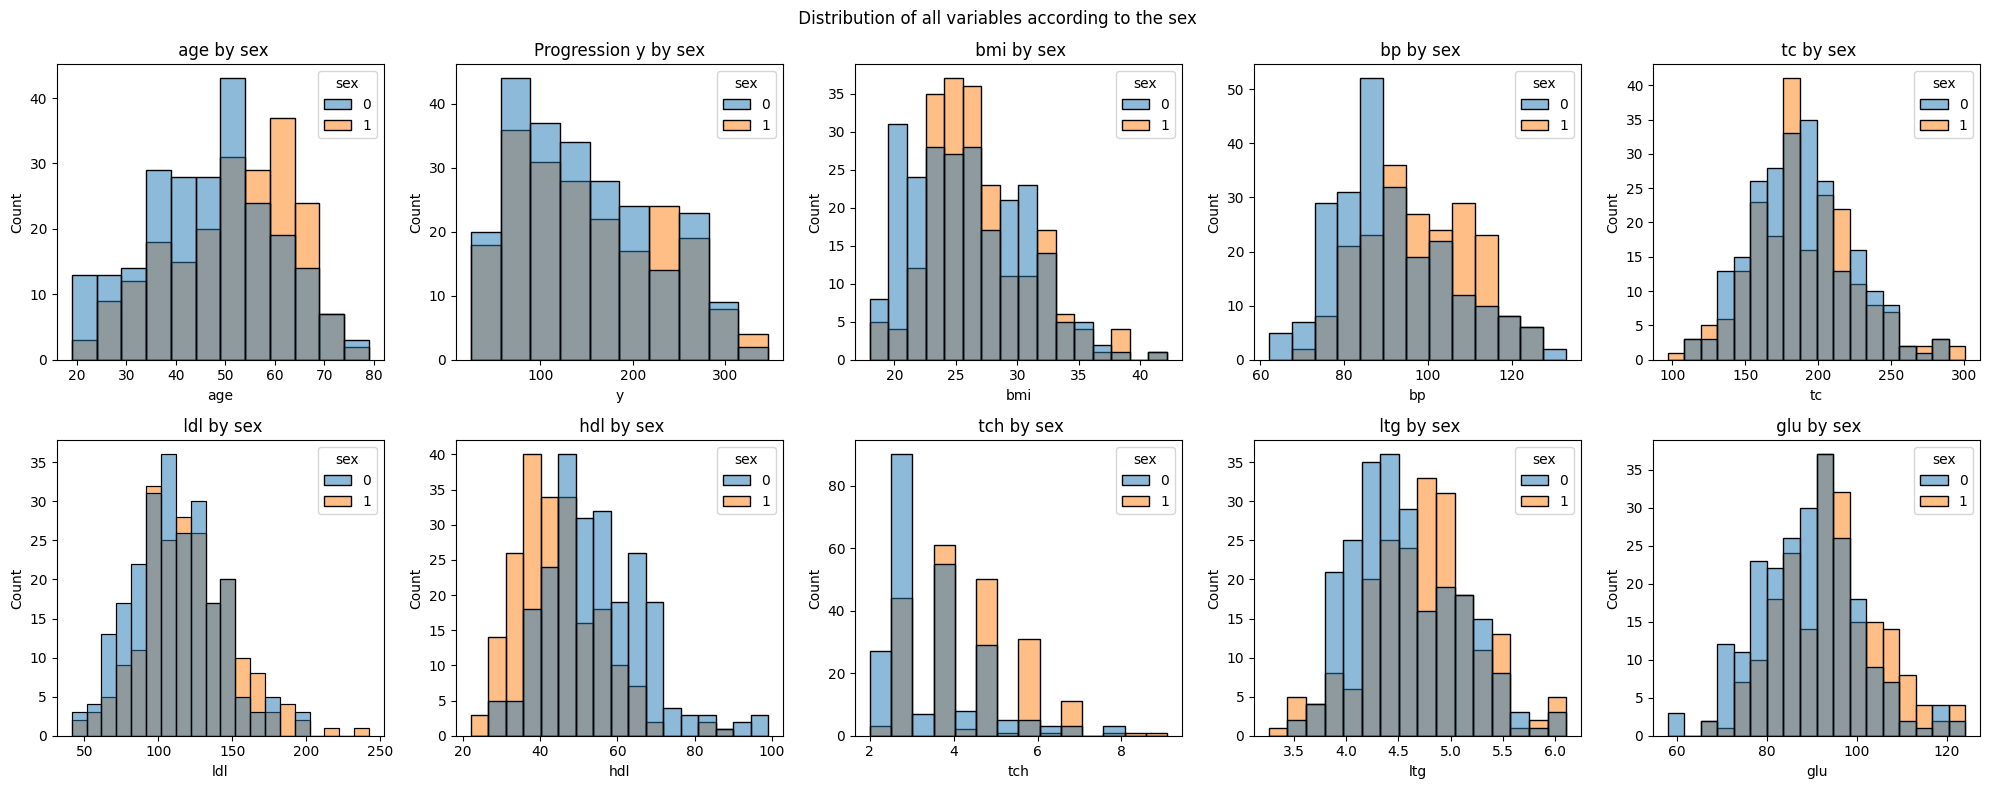

In [44]:
# Visualize the correlation of all variable and sex variable
fig, axes = plt.subplots(ncols=5, nrows=2, figsize=(20,8))
axes = axes.flatten()

for idx, col in enumerate(df.select_dtypes(include='number').columns): 
    if col != 'sex' and idx !=10:
        sns.histplot(df, x=col, hue='sex', ax=axes[idx])
        axes[idx].set_title(f" {col} by sex")
    elif col == 'sex': 
        sns.histplot(df, x='y', hue='sex', ax=axes[idx])
        axes[idx].set_title("Progression y by sex")
plt.suptitle(" Distribution of all variables according to the sex")
plt.tight_layout()
plt.show()

**Conclusion**
- There are no major gender differences in the distruibution of other explanatory variables or in target.

## Conclusion – Exploratory Data Analysis (EDA)

- The dataset includes 442 diabetic patients with a fairly balanced sex distribution (53% male, 47% female).
- The target variable **Y (disease progression)** has a mean of 152 and standard deviation of 77. It shows a slight right skewness.
- Patients are on average **overweight**, with a **mean BMI of 26.4**, but the most frequent classe is 'normal_weight'. And about **21.5% of the population is considered obese (BMI > 30)**.
- Correlation analysis suggests that **BMI and LTG** are the most correlated with the disease progression, but still moderately.
- The correlation analysis also shown that **TC** (total cholesterol) and **LDl** ("bad" cholesterol) are the most correlated variables, with r = 0.9. These variables will therefore be analyzed and processed before the modeling phase to avoid any form of multicollinearity.
- Age is normally distributed with a mean around 49 years and does not exhibit major differences across sex.
- No strong relationships between sex and the other explanatory variables, except potentially on HDL and LTG.

These insights will guide the choice of modeling strategies, notably the inclusion of BMI categories and further investigation on LTG and HDL. The low linear correlation with Y suggests that linear regression alone might be limited.


# Normality and Probability

**Probability and probability laws**  
To answer business questions such as:  "*What is the risk of a patient having a BMI over 30?*" or "*Can the male/female distribution be considered balanced?*", it is useful to study the probability laws underlying the variables.

By analyzing observed distributions and comparing them with theoretical laws (normal, Bernoulli...), we can both :
- deepen understanding of observed distributions,
- validate the assumptions required for statistical inference tools (estimators, intervals, tests),
- provide a more robust and generalizable interpretation of the phenomena observed in the sample.  

Indeed, many methods such as estimating a parameter (point estimator), calculating a confidence interval or carrying out statistical tests (e.g.: mean or proportion test) are based on distribution assumptions.

**Questions:**
- **What is the risk of a patient having a BMI over 30?**
- **Can the male/female distribution be considered balanced?**
- **Which variables have a normal distribution?** (age, bmi, tc, ldl, ltg, glu)


### **Distribution of men and women**
- Does sex follow an M/F Bernoulli law ~ success/failure?
- Can the male/female distribution be considered balanced?
- Can we estimate the proportion of men and women in the population?

**1. Point estimate of the male proportion**

In [45]:
# Empirical sample proportion
print(f"In our sample we have {n_males} hommes et {n_females}, ie {100*proportion_males:.1f}% of men and {100*proportion_females:.1f} of women")

In our sample we have 235 hommes et 207, ie 53.2% of men and 46.8 of women


- Is this difference due to chance or sample variation, or is it the result of a significant difference ?

**2. Hypothesis test: Balanced distribution ?**

Hypothesis:  

$
\left\{
\begin{array}{ll}
H_0 : & p_{\text{Men}} = p_0 \\
H_1 : & p_{\text{Men}} \neq p_0
\end{array}
\right.
$

$ p_0 = 0.5 $  
$ \text{alpha} = 0.05$

**2.a. Perform the proportion z-test**  

$$ z= \frac{\hat{p} − p_0}{\sqrt{\frac{p_0\times(1-p_0)}{n}}} $$

In [46]:
# ** Proportion test: z-test ** # Manual calculation
# Set siginicvity threshold 
alpha = 0.05
# Theoretical proportion (if balanced sample)
p_0 = 0.5 
p_hat = proportion_males
n = n_sample
print(p_0, proportion_males, n)

# Compute the z statistic
numerator = p_hat - p_0
denominator = np.sqrt(p_0 * (1 - p_0) / n)

z_score = numerator / denominator

# Calculate the p-value from the z-score
p_value = 2*(1 - norm.cdf(z_score))

# Print the p-value
print(p_value)

# Interpret the p_valvue
if p_value < alpha: 
    print(f"The p_value {p_value:.3f} < {alpha} therefore we reject the null hypothesis, and the M/F distribution cannot be considered balanced”")
else: 
    print(f"The p_value {p_value:.3f} > {alpha} therefore we don't reject the null hypothesis, consider the M/F distribution as balanced")


0.5 0.5316742081447964 442
0.18291796915910918
The p_value 0.183 > 0.05 therefore we don't reject the null hypothesis, consider the M/F distribution as balanced


**2.b. Bernoulli's law adequacy test**

In [47]:
# ** Proportion Test: z-test one_sample ** 
from statsmodels.stats.proportion import proportions_ztest

count = n_males      # number of "success" 
nobs = n_sample      # sample size
value = p_0          #H0 value : p0

stat, pval = proportions_ztest(count, nobs, value=value, alternative='two-sided')
print(stat, pval)

1.3345045734553072 0.18203854900974703


In [48]:
# ** Test de Bernoulli **
import statsmodels 

alpha = 0.05
p0 = 0.5

p_value = statsmodels.stats.proportion.binom_test(n_males,n_sample, prop=p0, alternative='two-sided')
print("La p-valeur du est : ", p_value)
if p_value < alpha: 
    print(f"The distribution of men and women does not follow a Bernoulli distribution with parameter e p=0.5")
else: 
    print(f"The distribution of males and females follows a Bernoulli distribution with parameter p=0.5. We can therefore consider the 'sex' distribution to be balanced")

La p-valeur du est :  0.1989965091445383
The distribution of males and females follows a Bernoulli distribution with parameter p=0.5. We can therefore consider the 'sex' distribution to be balanced


In [49]:
from scipy.stats import binomtest

result = binomtest(k=n_males, n=n_sample, p=p0, alternative='two-sided')
print(result.pvalue)

0.1989965091445383


**Interpretation of results**
- The distribution of men and women in the sample is well balanced. 
- We can even assert that this variable follows a Bernoulli distribution with parameter p = 0.5.
- _Here, we used a first approach with the normal distribution and the z-test with n*p_0 > 5, but the results from the bernoulli test are more precise_.

**4. Confidence interval for the proportion**

In [50]:
# Point Estimate 
print(f"We have already estimated the proportion of men in the EDA section, with  {proportion_males:.3f}, which is our point estimator.")

We have already estimated the proportion of men in the EDA section, with  0.532, which is our point estimator.


In [51]:
from statsmodels.stats.proportion import proportion_confint

# Calculate the confidence interval for the proportion of men
proportion_confint(count=n_males, nobs=n_sample, alpha=0.05, method='binom_test')  # IC 95%

(0.4841510231854729, 0.5781071055712883)

In [52]:
from scipy.stats import binom
ci_count = binom.interval(0.95, n=n_sample, p = proportion_males)
ci_prop = [x/n_sample for x in ci_count]
print(ci_count, ci_prop)

(np.float64(214.0), np.float64(256.0)) [np.float64(0.4841628959276018), np.float64(0.579185520361991)]


- If our sample is representative of the population, we can say that there are about 53% men in the population, with a 95% confidence interval of [48.4% , 57.8%].  
_NB: The interval is wide because the sample is small._

**5. Conclusion**
- In our sample, 53.2% of patients are male.
- A proportion test (z-test, p = 0.183) and a binomial test do not allow us to reject the hypothesis of a 50% balanced distribution.
- We therefore estimate that the proportion of men in the diabetic population represented here is compatible with a balanced proportion, with a 95% CI of [48.4%; 57.8%].    
_This estimate is consistent with global data (≈ 50.4% d’hommes à la naissance, source https://www.ined.fr/fr/tout-savoir-population/memos-demo/faq/plus-hommes-ou-femmes-sur-terre/)_

### Does Body Mass Index follow a normal distribution?
- **Does BMI follow a normal distribution ?**  
- **Can we calculate the probability of an individual being considered 'obese': P(bmi > 30) ?**

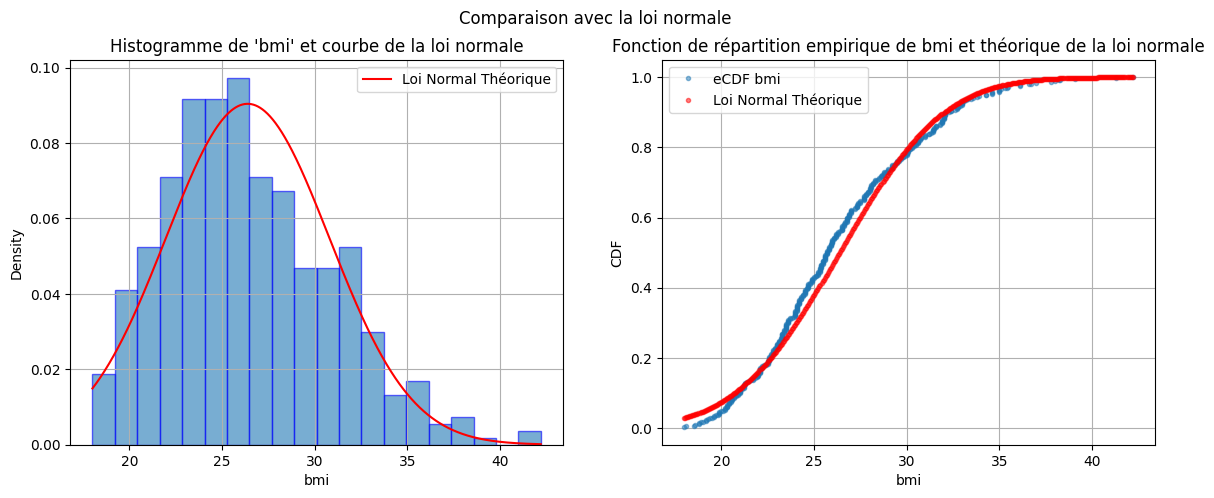


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic       p_value interpretation
0  Kolmogorov-Smirnov   0.070129  2.462828e-02      reject H0
1             Shapiro   0.972821  2.519594e-07      reject H0 
	 
Conclusion:
 - As the p_value < 0.05 for Kolmogorov-Smirnov test, so reject H0 and assume that bmi distribution IS NOT normal


In [53]:
# Visualization of bmi and the normal law
from stats_utils import compare_distribution_with_normal_distribution
mu = df['bmi'].mean()
sigma = np.std(df['bmi'])
n_var = len(df['bmi'])

compare_distribution_with_normal_distribution(df, 'bmi', mu, sigma, n_var)

# Perform statistical test
result, conclusion = test_stats_normality(df, 'bmi' , mu, sigma)
print(result,"\n\t", conclusion)

**Conclusion**
- When we compare the historgram to the density curve of the normal distribution, we see that the overall shape is close to normal, but with a slight asymmetry to the right. 
- bmi's eCDF is also close to the normal distribution function, but not perfectly. 
- But this visual similarity is not enough: the Kolmogorov-Smirnov and Shapiro Wilk tests reject normality with:
  - KS p_value = 0.0246 → which is borderline
  - Shapiro p_value = 2.5e-07 → strong rejection

_Knowing that the Shapiro Wilk test is sensitive to outliers, we can try to remove them in order to test adequacy to normal laws_.

In [54]:
# Removing outliers + Performing statistical Tests

n_rows = df['bmi'].shape[0]
print(f"- Before removing outliers, the dataset had {n_rows} rows")
z = zscore(df['bmi'])
n_outliers = df[~((z > -3) & (z < 3))].shape[0]
df_filtered = df[(z > -3) & (z < 3)]
n_rows = df_filtered.shape[0]
print(f"- If we delete {n_outliers} outliers of 'bmi' variables (with the z-score method), and then we perform again the statistical tests on the {n_rows} remaining rows, we have: ")

result, conclusion = test_stats_normality(df_filtered, 'bmi' , mu, sigma)
print(result, conclusion)

- Before removing outliers, the dataset had 442 rows
- If we delete 2 outliers of 'bmi' variables (with the z-score method), and then we perform again the statistical tests on the 440 remaining rows, we have: 

 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value interpretation
0  Kolmogorov-Smirnov   0.072567  0.018456      reject H0
1             Shapiro   0.976055  0.000001      reject H0 
Conclusion:
 - As the p_value < 0.05 for Kolmogorov-Smirnov test, so reject H0 and assume that bmi distribution IS NOT normal


- After removing outliers. Tests always reject normality with p_value < 0.05.
    - KS with p_value = 0.0184 (≈ which is rather stable)
    - Shapiro: p_value = 1e-6 → although the p_value has evolved a lot, we still strongly reject the adequation to a normal distribution.

_As removing the outliers did not make the variable normal, we tested other methods. The skewness on the right suggests that a logarithmic transformation would make the variable normal_

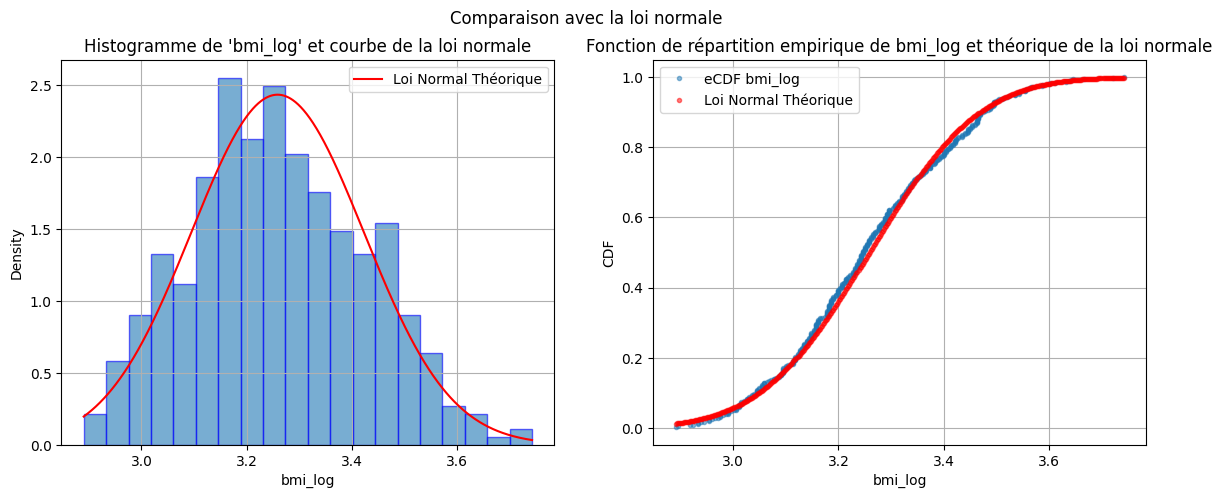


 bmi_log présente un skewness = 0.206. 
 

 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.038057  0.531342  fail to reject H0
1             Shapiro   0.991860  0.016068          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that bmi_log distribution IS normal


In [55]:
# Transformation log 
df['bmi_log'] = np.log(df['bmi']) # Toutes les valeurs bmi > 0 donc on peut faire une transformation log 

# Calcul des stats
mu = df['bmi_log'].mean()
sigma = np.std(df['bmi_log'])
n_var = len(df['bmi_log'])

# Visualisation du bmi et loi normale
compare_distribution_with_normal_distribution(df, 'bmi_log', mu, sigma, n_var)

# Caclul du Skewness 
skewness = df['bmi_log'].skew().item()
print(f"\n bmi_log présente un skewness = {skewness:.3f}. \n ")
# Effectuons les tests statistiques
result, conclusion = test_stats_normality(df, 'bmi_log' , mu, sigma, 0.05)
print(result)
print(conclusion)

- After a logarithmic transformation, the distribution becomes visually more symmetrical, and skewness decreases.

However, the test results are ambiguous:
- The ks has a p_value > 0.05, suggesting that the log_bmi distribution approaches a normal distribution.
- But the Shapiro test strictly rejects the normal distribution with a p_value < 0.05.

**Conclusion**: We will use log(bmi) for inferential analyses requiring normality (stats tests), while keeping bmi raw for descriptive analyses and business interpretations.

**Probability of obesity**
- We also want to estimate the proportion of obese people in the population.
- A first approach will be to estimate this proportion using the empirical mean of our sample.
- And a second approach, using the probability

NB: After logarithmic transformation of the bmi variable, the normality assumption has become acceptable (p > 0.05). To ensure correct interpretation, the probabilities and thresholds of interest (e.g. BMI > 30) were converted into the transformed scale before calculation.

In [56]:
# Probability calculation
# P(bmi > 30) -> P(log(bmi) > log(30))
mu = df['bmi_log'].mean()
sigma = np.std(df['bmi_log'])
threhold_obese = np.log(30)
proba = 1 - norm.cdf(threhold_obese, mu, sigma)
print(f"P(bmi > 30) (via log-normalisation) ≈ {proba:.4f}")

P(bmi > 30) (via log-normalisation) ≈ 0.1927


**Conclusion**:
- The empirical proportion of obese patients (BMI > 30) in our sample is 21%.
- The probability estimated via the transformed normal distribution (log(bmi)) gives a slightly lower value (≈ 19.5%).  
                                                                                                             
This difference can be explained by the fact that the probability is calculated under an assumption of normality, whereas the proportion is a rough measure. The confidence interval for this proportion is based on the empirical value, as it directly reflects the uncertainty associated with sampling.

### **Assess the normality assumption for the following variables: age, tc, ldl, glu, and y (disease progression)**

age


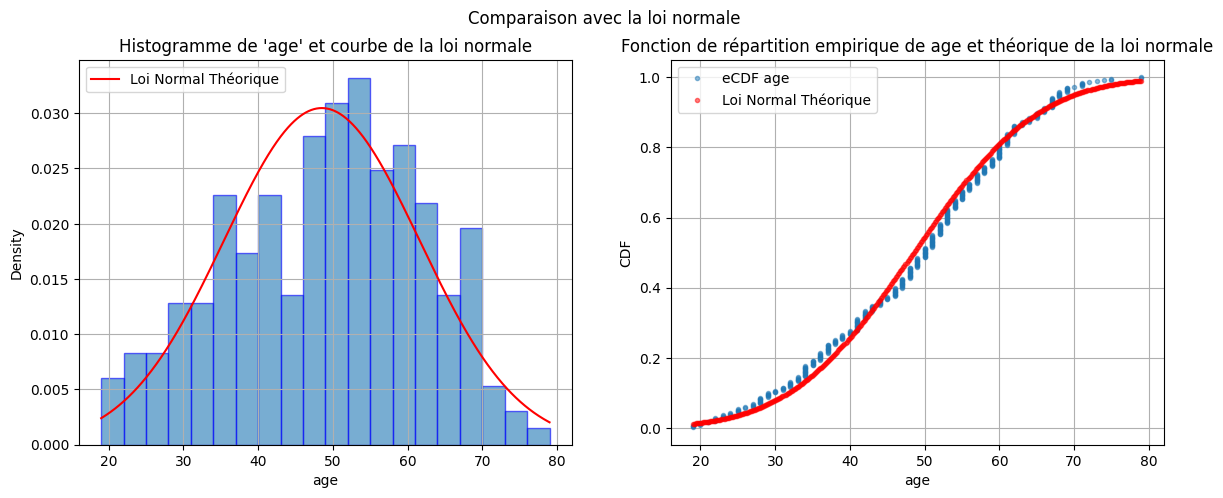


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.061591  0.067032  fail to reject H0
1             Shapiro   0.982358  0.000033          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that age distribution IS normal


In [57]:
# Age
test_normality(df, 'age')

tc


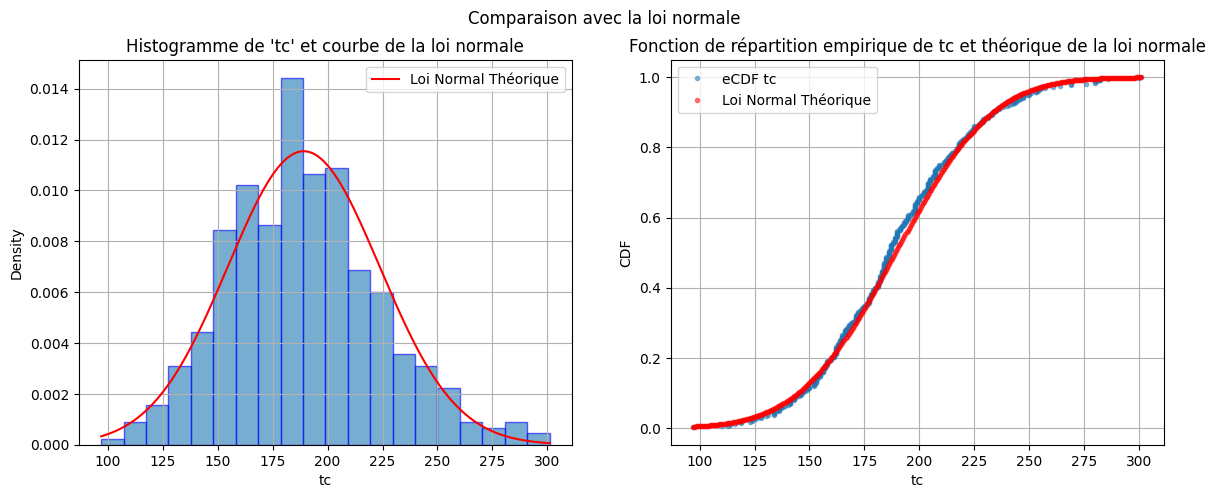


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.051165  0.190856  fail to reject H0
1             Shapiro   0.990279  0.005129          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that tc distribution IS normal

**Removing Outliers**

 Here, as we know the Shapiro test is sensitive to outlier, we will remove them (using the zcore method)
	 Before removing outlier we had 442 rows
	 After removing outlier we have 440 rows
Re testing the normality:

 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.053716  0.152194  fail to reject H0
1             Shapiro   0.992728  0.031217          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that tc di

In [58]:
# Total cholestérol
from stats_utils import test_normality
alpha = 0.05
test_normality(df, 'tc', alpha, remove_outlier=True)

low_density_lipoproteins
ldl


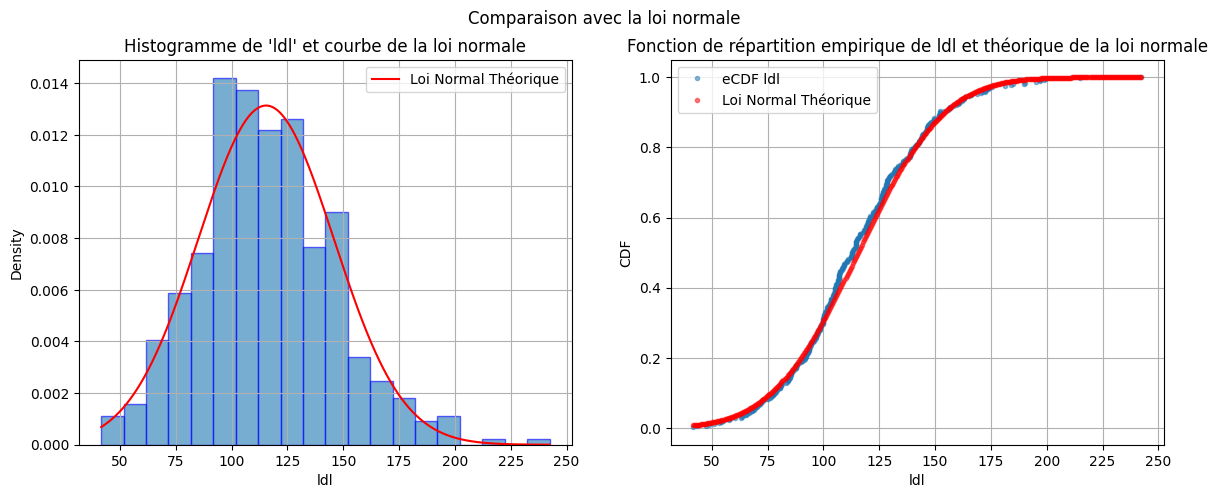


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.049779  0.216126  fail to reject H0
1             Shapiro   0.988303  0.001309          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that ldl distribution IS normal


In [59]:
# Tester la normalité de ldl
print(column_long_name['ldl'])
test_normality(df, 'ldl')

glu


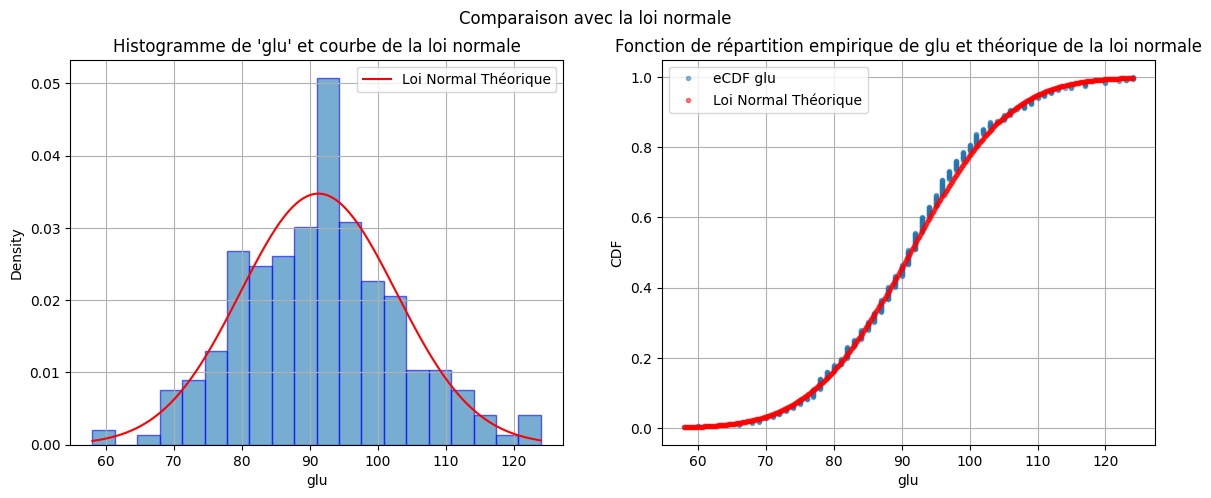


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.048037  0.251381  fail to reject H0
1             Shapiro   0.993123  0.040951          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that glu distribution IS normal

**Removing Outliers**

 Here, as we know the Shapiro test is sensitive to outlier, we will remove them (using the zcore method)
	 Before removing outlier we had 442 rows
	 After removing outlier we have 442 rows
Re testing the normality:

 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic   p_value     interpretation
0  Kolmogorov-Smirnov   0.048037  0.251381  fail to reject H0
1             Shapiro   0.993123  0.040951          reject H0

Conclusion:
 - As the p_value > 0.05 for Kolmogorov-Smirnov test, so we do not reject H0 and assume that glu 

In [60]:
# Tester la normalité du taux de sucre
test_normality(df, 'glu', remove_outlier=True)

y


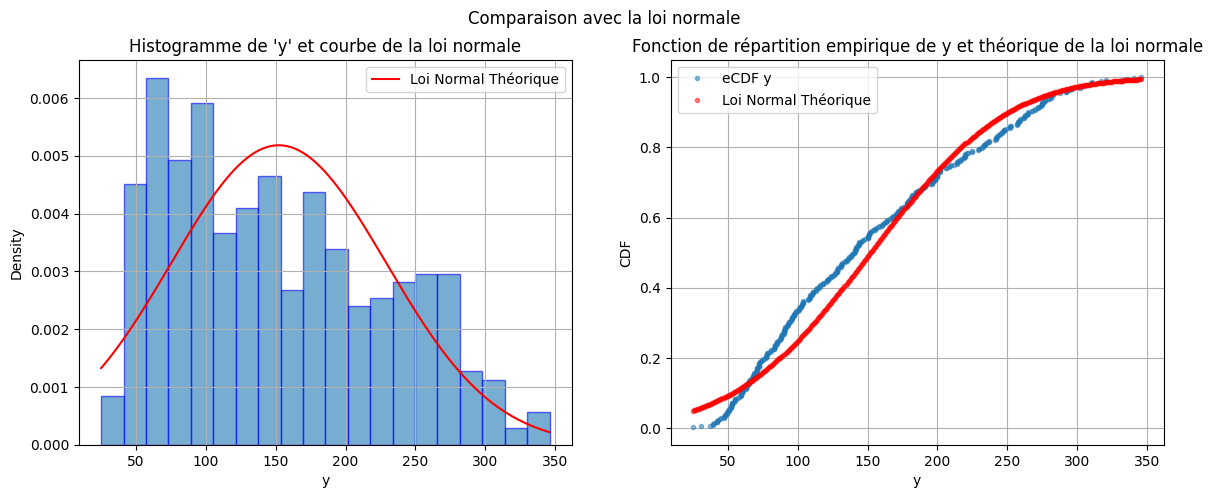


 **Tests d'adéquation à la loi normale - Normality Tests**
alpha = 0.05
                 Test  statistic       p_value interpretation
0  Kolmogorov-Smirnov   0.096026  5.340022e-04      reject H0
1             Shapiro   0.949058  3.363544e-11      reject H0

Conclusion:
 - As the p_value < 0.05 for Kolmogorov-Smirnov test, so reject H0 and assume that y distribution IS NOT normal


In [61]:
# La variable de la progression est elle normale ? 
test_normality(df, 'y')

### Conclusion

**Conclusion on the Normality of Variables**

The Kolmogorov-Smirnov (KS) test appeared to be more robust to outliers, whereas the Shapiro-Wilk test is highly sensitive, especially to slight asymmetries in the data. Due to this sensitivity, the KS test will be preferred when assessing the normality of distributions.

According to the results:
- The variables 'tc' and 'ldl' have distributions reasonably close to normal.
- The variable 'glu' lies at the threshold: KS p > 0.05, but Shapiro p = 0.041. This suggests an approximately normal distribution, though with some caveats.
- The variables 'age' and 'y' (the response) do not follow a normal distribution according to either test.

→ These findings will inform the choice of appropriate statistical methods in the following steps (e.g., parametric vs. non-parametric tests, modeling strategies).

# Sampling, Estimation and Confidence Intervals

Estimate unknown parameters of the diabetic population from the available sample.

**Estimation and Confidence Intervals**

In this section, we illustrate how sampling and estimators can be used to infer the true parameters of the population such as proportions, means, and variances. We also demonstrate how confidence intervals help quantify the uncertainty surrounding these estimates, with a focus on realistic, business-oriented questions:
1. What proportion of diabetic patients are affected by obesity, and to what extent can this finding be generalized?
2. What is the expected average progression of the disease one year after diagnosis? What is the variability of this progression?
3. What if we only had access to a partial sample of 100 patients? Can we trust the estimates obtained from such a subset?

### **1. Estimating the proportion of obese patients**

- What is the proportion of obese patients in the diabetic population, and to what extent can this information be generalized?

In [62]:
# Obese proportion in the sample
bmi_obese = df['bmi'] > 30
p_hat_obese = bmi_obese.mean()
print(f"The proportion of obese patients in the sample is {p_hat_obese:.3f}")

The proportion of obese patients in the sample is 0.215


In [63]:
# Confidence interval for a proportion 
alpha = 0.05
z = norm.ppf(1-alpha/2)
ci_lower = p_hat_obese - z*np.sqrt(p_hat_obese*(1- p_hat_obese)/ n_sample)
ci_upper = p_hat_obese + z*np.sqrt(p_hat_obese*(1- p_hat_obese)/ n_sample)
print(f"95% CI for proportion of obese patients : [{ci_lower:.3f}, {ci_upper:.3f}]")

95% CI for proportion of obese patients : [0.177, 0.253]


In [64]:
# Verification of this confidence interval
proportion_confint(count=bmi_obese.sum(), nobs=n_sample, alpha=0.05, method='normal')

(0.17663720136754207, 0.2532270520261231)

Among the 442 patients, 21% were obese (BMI > 30). Assuming random sampling, we can estimate that the actual proportion of obese patients in the general population is between 17.8% and 25.3%, with a confidence level of 95%.  
Assuming that the 'bmi' would follow a normal distribution after log transformation, we obtained that the probability of being obese was 19%. This value is consistent with our confidence interval, although it is preferable to communicate the confidence interval figures as they are based on our sample and not a strict normal law.

### **2. Estimation of the mean y progression and its variability**
- What is the expected mean progression of the disease one year after diagnosis? 
- What is the expected variability of this progression?

In this case, the dataset represents a sample of patients followed by the clinic. Therefore, we'll use the variance and standard deviation formulas for samples in _n-1_.   
$ \text{variance}: \text{S'²} = \frac{1}{n-1} \times \sum_{i=1}^{n} (x_i - \overline{x})^2 ~~$  &  $~~\text{standard deviation}: \sigma' = \sqrt{ \frac{1}{n-1} \times \sum_{i=1}^{n} (x_i - \overline{x})^2}$ 

In [65]:
# Point estimates of mean and standard deviation 
y_bar = df['y'].mean()
s_prime_y = np.std(df['y'], ddof=1)
print(f"The average progression after 1 year is {y_bar:.2f} with a standard deviation of {s_prime_y:.2f}")

The average progression after 1 year is 152.13 with a standard deviation of 77.09


In [66]:
# Confidence interval of the mean of the progression y 
# Context: n > 30 but the progression is not normal and the standard deviation of the population is not known, so we'll use t-distribution
alpha = 0.05
dof = n_sample - 1
t_stat = t.ppf(1 - alpha/2, df= dof)
se = s_prime_y / np.sqrt(n_sample)

ci_upper = y_bar + t_stat * se
ci_lower = y_bar - t_stat * se 
print(f" 95% CI is: [{ci_lower:.3f} , {ci_upper:.3f}]")

 95% CI is: [144.927 , 159.340]


In [67]:
# 95% CI with scipy
ci_low, ci_high = t.interval(confidence= 1-alpha, df=n_sample-1, loc=y_bar, scale=se)

print(f"The COnfidence Interval at 95% : [{ci_low:.3f}, {ci_high:.3f}]")

The COnfidence Interval at 95% : [144.927, 159.340]


The mean progression of diabetes one year after diagnosis is estimated at 152.13. The 95% confidence interval [144.93; 159.34] reflects the uncertainty associated with this estimate. This means that, if we were to repeat this study several times, 95% of the CIs constructed would contain the true population mean.

In [68]:
# Confidence interval on variance 
s2 = np.var(df['y'], ddof=1)

alpha = 0.05
chi2_inf = chi2.ppf(alpha/2, df=n_sample-1)
chi2_sup = chi2.ppf(1 - alpha/2, df=n_sample-1)

ci_var_lower = (n_sample - 1) * s2 / chi2_sup
ci_var_upper = (n_sample - 1) * s2 / chi2_inf
(ci_var_lower, ci_var_upper)
print(f"The observed variance of the progression is {s2:.2f} with a 95% CI of [{ci_var_lower:.2f}, {ci_var_upper:.2f}]")

# Ecart-type
ci_std_lower = np.sqrt(ci_var_lower)
ci_std_upper = np.sqrt(ci_var_upper)
print(f"The observed standard deviation of the progression is  {s_prime_y:.2f} with a 95% CI of [{ci_std_lower:.2f}, {ci_std_upper:.2f}]")

The observed variance of the progression is 5943.33 with a 95% CI of [5230.74, 6812.97]
The observed standard deviation of the progression is  77.09 with a 95% CI of [72.32, 82.54]


### **3. Sample simulation & estimator**
What if we only had a partial sample of 100 patients? Can we trust the estimates derived from this sub-sample?

In [69]:
# Simulation d'échantillonnage 
sub_sample = df.sample(n=100, replace=False, random_state=2025)
sub_sample

# Estimateur ponctuelle
y_sub_bar = sub_sample['y'].mean()
s_sub_prime = np.std(sub_sample['y'], ddof=1)
s2_sub = np.var(sub_sample['y'], ddof=1)
print(y_sub_bar, s2_sub, s_sub_prime)

147.06 6273.6327272727285 79.2062669696832


In [70]:
# Estimer la moyenne avec le TCL 
np.random.seed(seed=2)
sample_mean_list = []
for _  in range(1000):
    sample = df.sample(n=100)
    sample_mean_list.append( sample['y'].mean())

mean_of_sample_means = np.mean(sample_mean_list)
print(mean_of_sample_means)
print(f"The population mean is = {np.mean(df['y']):.2f} and the mean of the sample distribution {mean_of_sample_means:.2f}")

151.98074
The population mean is = 152.13 and the mean of the sample distribution 151.98


In [71]:
# Estimate the standard deviation by bootstrapping
np.random.seed(seed=3)
sample_std_list = []
for _  in range(1000):
    sample = df.sample(n=100, replace=True)
    sample_std_list.append( np.std(sample['y'], ddof=1))
np.mean(sample_std_list)
print(f"The std of the population is = {np.std(df['y']):.2f} and the std of the boostrapped samples is {np.mean(sample_std_list):.2f}")

The std of the population is = 77.01 and the std of the boostrapped samples is 77.13


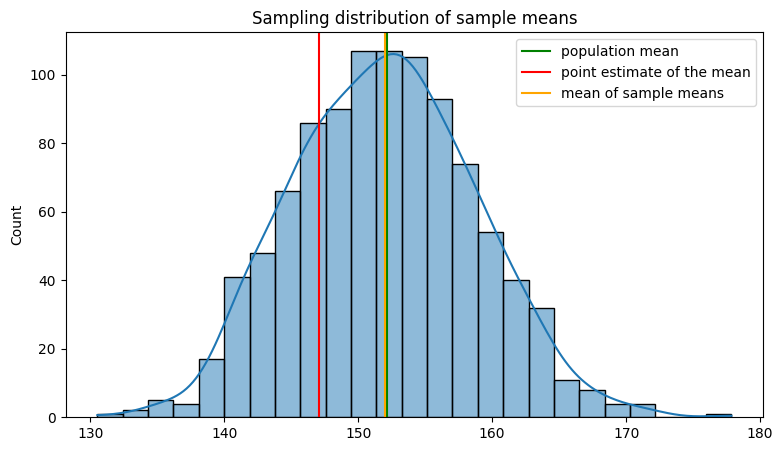

In [72]:
# Viz sample_mean
fig = plt.figure(figsize=(9,5))
sns.histplot(sample_mean_list, kde=True)

# Ajouter moyenne de la population, estimateur ponctuelle, moyenne de la distribution des moyennes des échantillons
plt.axvline(y_bar, color='green', label='population mean')
plt.axvline(y_sub_bar, color='r', linestyle = '-', label='point estimate of the mean')
plt.axvline(mean_of_sample_means, color='orange', linestyle = '-', label='mean of sample means')
plt.title("Sampling distribution of sample means") 
plt.legend()
plt.show()

- Estimators obtained by simulating 1000 samples are much closer to population values than point estimators.
After sampling:
- When only a sample of 100 patients is available, the point estimate may fluctuate (e.g. mean = 147.06). However, the mean of the means over 1000 simulated samples converges to the true value (≈151.98), illustrating the effect of the law of large numbers.

# Statistical Test

- Is there a significant difference in average bmi between women and men? (Welch)
- Same for diabetes progression (Welch)
- And what about glucose? (t-test)
- Do sugar levels vary according to bmi category (normal, overweight, etc.)? (anova test)
- Does diabetes progression depend on bmi category? (Krustal Wallis)
- Is sex a factor in obesity? Are more men obese than women? (chi2) 

**Objective**: to determine whether certain variables have a significant effect on others, using suitable hypothesis tests.**

**Section outline**

- **1. Comparison of means (t-test / Welch)**
- **2. Comparison of several groups (ANOVA / Kruskal-Wallis)**
- **3. Association between categorical variables (Chi²)**.
- **4. Parametric vs. non-parametric choice**.
- **5. Summary of results**

#### **1. Are there differences in BMI between women and men?**

##### **1. Test: difference in BMI between men and women**.

**Objective**: To test whether there is a significant difference in BMI between the sexes.

- $ \{ H_0 $ : There is **no difference** in BMI between men and women.
- $ \{ H_1 $ : There is a **significant difference**.

**Choice of test**: t-test  
- $ \alpha $ = 0.05

**Assumptions to be checked when performing a t-test** :
- Male/female groups are independent. 
- The 'bmi' variable is not normal.
- But its 'log(bmi)' transform follows an approximately normal distribution in the data set. Check that the distribution is still normal in each group.
- Check that variances are similar. 

In [73]:
# Mean_bmi by gender
df.groupby('sex')['bmi'].agg(['count', 'mean'])

,count,mean
sex,,
0,235,26.010638
1,207,26.790338


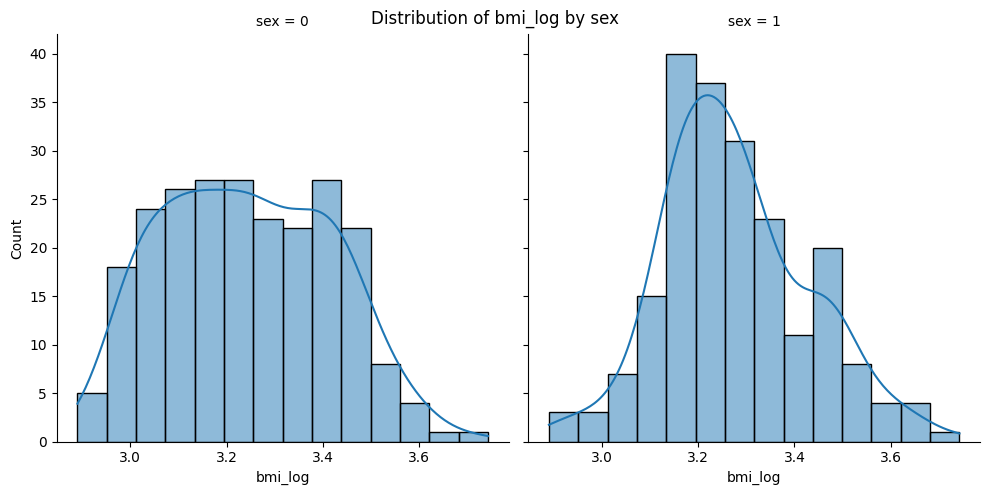

The p_value of bmi_log of men is 0.0011517216377491073 < 0.05, so we reject the null hypothesis, and considere that distribution is not normal
The p_value of bmi_log of women is 0.007324295245165233 < 0.05, so we reject the null hypothesis, and considere that distribution is not normal


In [74]:
# Let's check whether bmi follows the normal distribution within each group
# Plot distribution 
variable = 'bmi_log'
sns.displot(data=df, x= variable, col='sex', kde=True)
plt.suptitle(f"Distribution of {variable} by sex")
plt.show()

# Test de shapiro 
distrib_homme = df[variable][df['sex']==0]
distrib_femme = df[variable][df['sex']==1]

alpha = 0.05
stat_homme, p_value_homme  = shapiro(distrib_homme)
stat_femme, p_value_femme  = shapiro(distrib_femme)

# Interprétation 
if p_value_homme < alpha: 
    print(f"The p_value of {variable} of men is {p_value_homme} < {alpha}, so we reject the null hypothesis, and considere that distribution is not normal")
else: 
    print(f"The p_value of {variable} of men is {p_value_homme:.4f} > {alpha}, so we fail to reject the null hypothesis, and considerate the distribution as normal")
if p_value_femme < alpha:
    print(f"The p_value of {variable} of women is {p_value_femme:} < {alpha}, so we reject the null hypothesis, and considere that distribution is not normal")
else: 
    print(f"The p_value of {variable} of women is {p_value_femme:.4f} > {alpha}, so we fail to reject the null hypothesis, and considerate the distribution as normal")

- the bmi_log variable is not normally distributed by group, so we can't perform a t-test

In [75]:
# Test d'égalité des variance 
    # HO: the variances are equals 
    # H1: the variances are not equals
alpha = 0.05 # Definir le seuil 
bmi_log_homme = df['bmi_log'][df['sex']==0]
bmi_log_femme = df['bmi_log'][df['sex']==1]
stat, p_value = levene(bmi_log_homme, bmi_log_femme)
if p_value < alpha: 
    print("The variances are not equal")
else:
    print("The variances are equal")

The variances are not equal


- As the variances are not equal, we will perform the Welch & Mann-Whitney test.

In [76]:
# Welch
welch_result = ttest_ind(bmi_log_homme, bmi_log_femme, equal_var=False)
print(welch_result)

# Mann-Whitney
mwu_result = mannwhitneyu(bmi_log_homme, bmi_log_femme, alternative='two-sided')
print(mwu_result)

TtestResult(statistic=np.float64(-2.1259510526032863), pvalue=np.float64(0.03406358120694857), df=np.float64(439.99460636151446))
MannwhitneyuResult(statistic=np.float64(21562.5), pvalue=np.float64(0.039465910197960315))


- For both tests, the p_values < 0.05, so we reject the null hypothesis H0: the logarithm of the mean bmi is equal for men and women.

##### Conclusion
**Test used** : Welch’s t-test and Mann Whitney U on 'log(bmi)'  
**Interpretation** :  
Men and women have **statistically different** BMIs, even after log transformation.  
This could reflect morphological differences within the study population.

#### **2. Is there a significant difference in mean glucose levels between men and women?**

##### Test
**Objective**: To test whether there is a significant difference in glucose levels between the sexes.

- $ \{ H_0 $ : There is **no difference** in sugar levels between men and women.
- $ \{ H_1 $ : There is a **significant difference**.

**Choice of test**: t-test  
- $ \alpha $ = 0.05

**Hypotheses to check when performing a t-test** :
- Male/female groups are independent. 
- The 'glu' variable is normal. But check that the distribution is always normal in each group.
- Check that variances are similar. 

Test if there is a significant differences of the average glu, between the sex, at the significant level alpha = 0.05


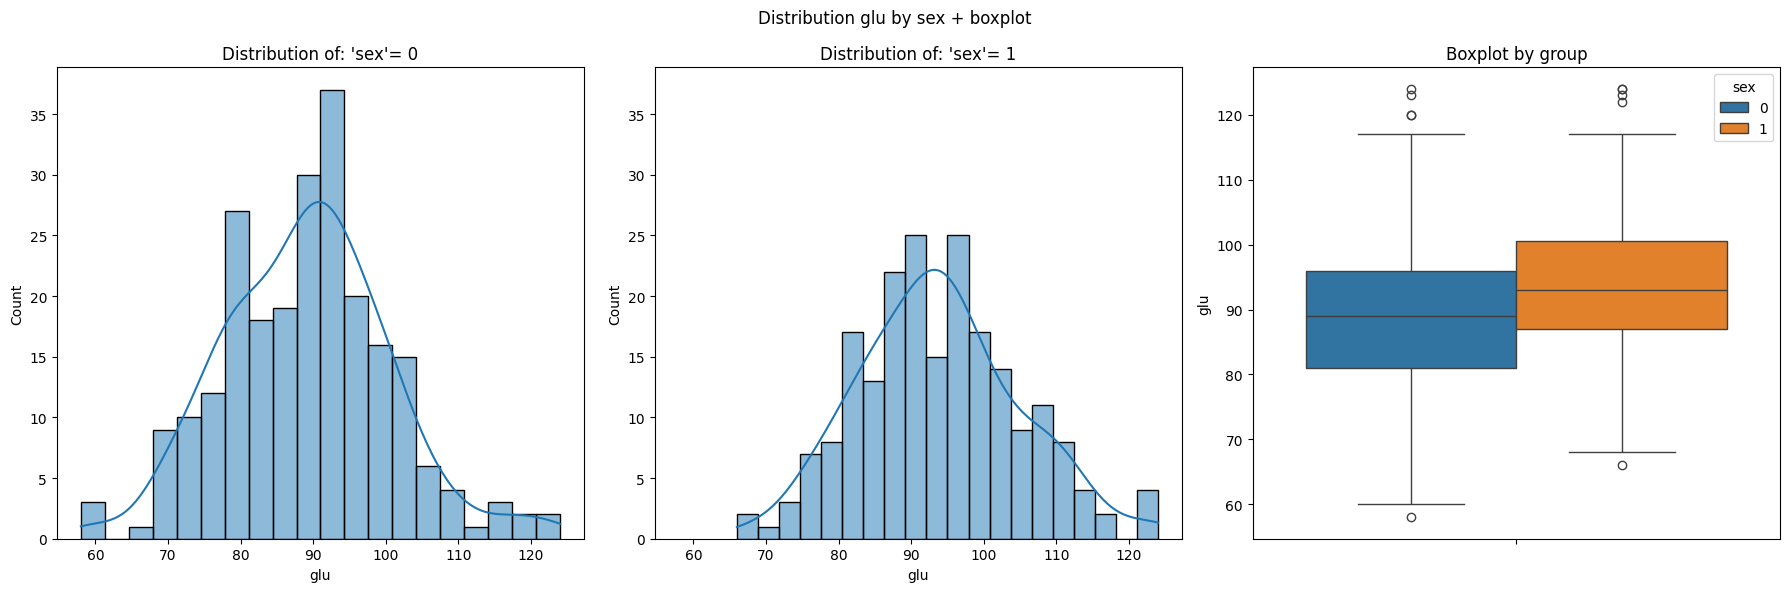


	**Test de shapiro**
The p_value for 'sex = 0' is 0.0967 > 0.05, so we fail to reject the null hypothesis, and considerate the distribution as normal
The p_value for 'sex = 1' is 0.2244 > 0.05, so we fail to reject the null hypothesis, and considerate the distribution as normal

	**Test de levene**
Les variance sont égales

	** T-test **
stat =-4.4635896099184285, p_value = 1.0253120038443073e-05
The p_value < 0.05, we rejet the null hypothesis, and the conclude that there is a significant difference between each 'sex' groups


In [77]:
from stats_utils import test_moyenne_2_groupes_def
alpha = 0.05
test_moyenne_2_groupes_def(df, 'glu', 'sex')

In [78]:
# Réalisons le t-test manuellement à l'aide la formule
# t-test à 2 échantillons # Calcul manuel
from scipy import stats
glu_homme = df['glu'][df['sex']==0]
glu_femme = df['glu'][df['sex']==1]

glu_h_bar = glu_homme.mean()
glu_f_bar = glu_femme.mean()

s_glu_h = np.std(glu_homme, ddof = 1)
s_glu_f = np.std(glu_femme, ddof = 1)

t_score = (glu_h_bar - glu_f_bar)/np.sqrt((s_glu_h**2/n_males) + (s_glu_f**2/n_females))
print(t_score)

2*(1 - stats.t.cdf(t_score, df= 440))
p_value =  2 * stats.t.cdf(t_score, df=440) # as t-test score < 0 
print(p_value)

-4.471506751856128
9.896641594597547e-06


- With the manual calculation performed using this formula,
- we end up with the same statistic stat = -4.46, but with a slight difference between the p-values (-3.56e-07) due to the approximations made during the cdf() calculation.
- But we arrive at the same conclusion: p_value < 0.05, so we reject the null hypothesis.

In [79]:
# t-test à 2 échantillon avec scipy
stats.ttest_ind(glu_homme, glu_femme, equal_var=True, alternative = 'two-sided')

TtestResult(statistic=np.float64(-4.4635896099184285), pvalue=np.float64(1.0253120038443073e-05), df=np.float64(440.0))

##### Conclusion
**Hypothesis verified**:
- normal variable by group
- similar variances

**Test used**: t-test on 'glu'  
**Interpretation**:  
Men and women have statistically different glucose levels.

#### **3. Is there a significant difference in average progression Y between women and men?**

##### Test
**Objective**: To test whether there is a significant difference in the response y between the sexes.

- $ \{ H_0 $: There is **no difference** in the progression y between men and women.
- $ \{ H_1 $: There is a **significant difference**.

**Choice of test**: Mann-Whitney U
- $ \alpha $ = 0.05

**Hypotheses to be verified**:
- The male/female groups are independent.
- The variable 'y' is not normal. But this is not a necessary condition for this test.
- Check whether the variances are similar.

y = progression_y
Test if there is a significant differences of the average y, between the sex, at the significant level alpha = 0.05


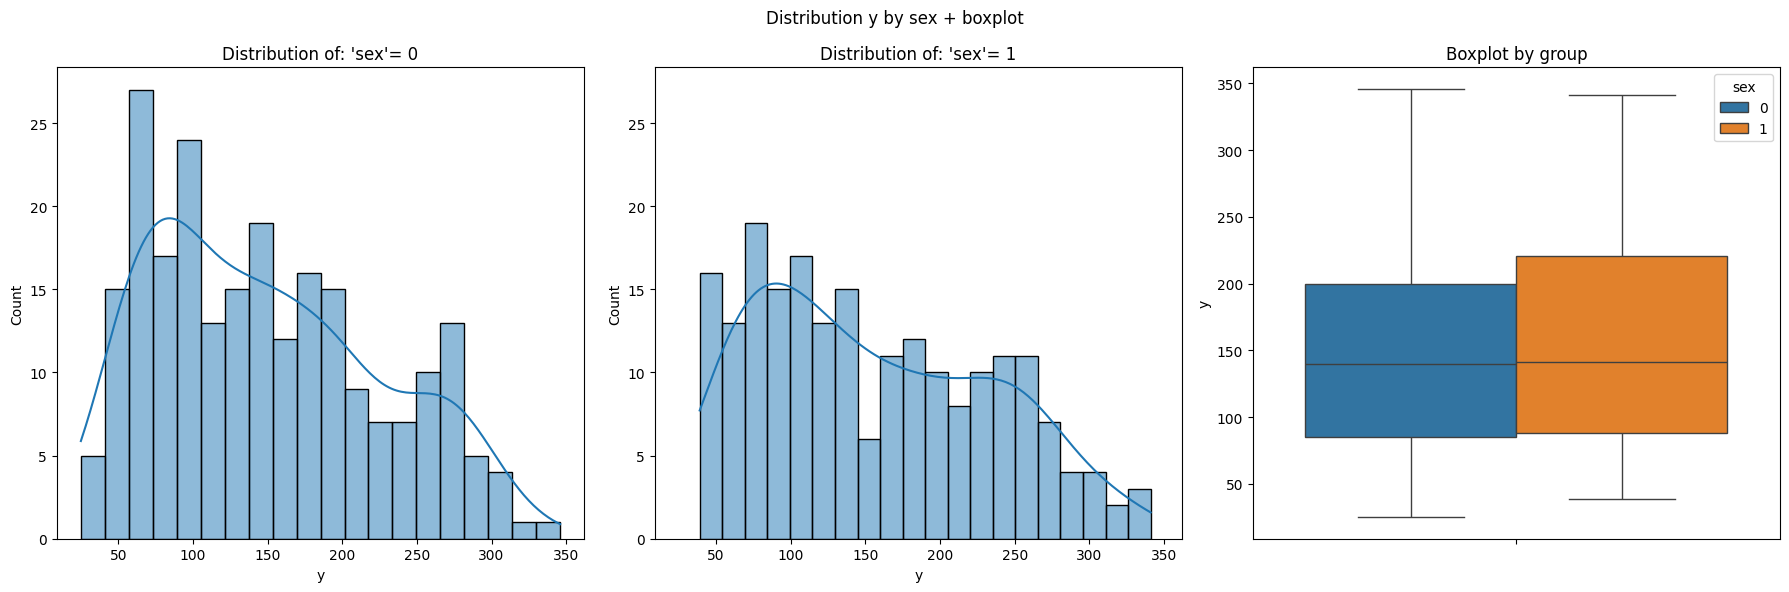


	**Test de shapiro**
The p_value for 'sex = 0' is 2.0071299814161734e-07 < 0.05, so we reject the null hypothesis, and considere that distribution is not normal
The p_value for 'sex = 1' is 6.98349695157588e-07 < 0.05, so we reject the null hypothesis, and considere that distribution is not normal

	**Test de levene**
Les variance sont égales

	** Mann Whitney U**
As the y is not normaly distributed within the group, we will perform the Mann Whitney U test, and we also perform Welch’s t-test (since n > 30), for comparison.
             test     statistic   p_value
0           Welch     -0.902222  0.367445
1  Mann Whitney U  23270.000000  0.432428 

The p_value: 0.4324 > 0.05, we fail to rejet the nullhypothesis, and the conclude that there is no significant difference between each 'sex' groups


In [80]:
from stats_utils import test_moyenne_2_groupes_def
print(f"y = {column_long_name['y']}")
alpha = 0.05
test_moyenne_2_groupes_def(df, 'y', 'sex', alpha=alpha)

##### Conclusion
**Used Test**: Mann Whitney U test on 'y'  
**Interprétation**:  
The null hypothesis is not rejected, and therefore there are no statistical differences in progression between men and women.  
_This suggests that, in this cohort of diabetic patients, gender does not appear to influence disease progression during the year following diagnosis._


Previously, we wondered whether gender is a factor that influences glucose levels or progression. It turned out that:
- there is indeed a significant difference in blood sugar levels between men and women
- but that gender does not seem to influence progression.

- _**But what about BMI class? Does BMI category influence glucose levels or progression?**_

#### **4. Is there a difference between different BMI classes in relation to glucose levels?** 

##### Test
- $ \{ H_0 $: There is **no significant difference** between the individual group means.
- $ \{ H_1 $: There is a **significant difference**.

**Test choice**: ANOVA
- $ \alpha $ = 0.05

**Hypotheses to be verified**:
- The BMI categories are independent.
- Cholesterol is a numeric variable.
- The 'tc' variable is approximately normal. However, it is necessary to verify that normality is maintained in each group.
- Check whether the variances in each group are approximately equal.

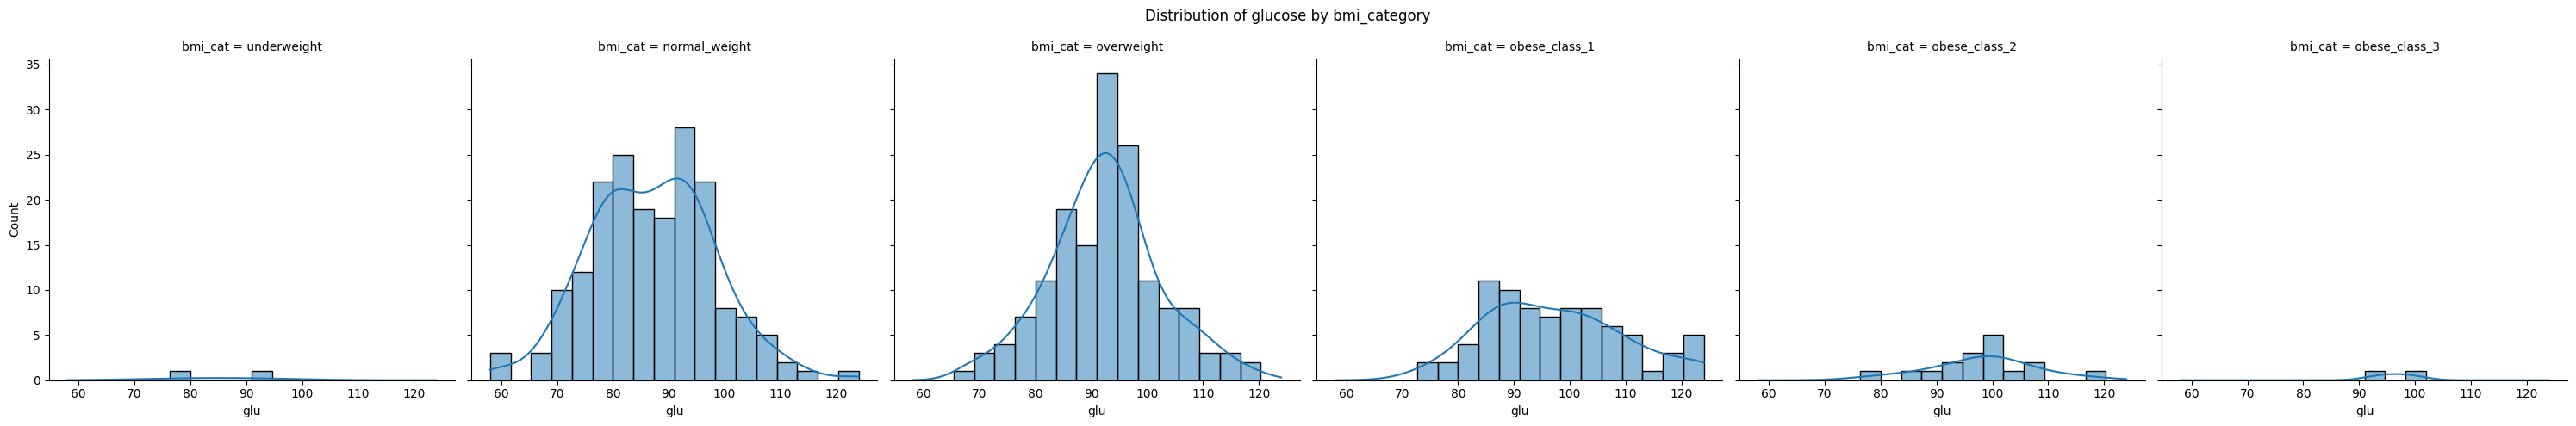

In [81]:
# Let's check normality by group
sns.displot(data=df, x='glu', col='bmi_cat', kde=True)
plt.suptitle("Distribution of glucose by bmi_category")
plt.tight_layout()
plt.show()

In [82]:
# Test de shapiro 
variable = 'glu'
group_value = df['bmi_cat'].cat.categories.tolist()
for i in group_value: 
    print(f"\n{i}:")
    print(shapiro(df[df['bmi_cat'] == str(i)][variable]))


underweight:
ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))

normal_weight:
ShapiroResult(statistic=np.float64(0.9936064746358401), pvalue=np.float64(0.5998423573636585))

overweight:
ShapiroResult(statistic=np.float64(0.9893194706586345), pvalue=np.float64(0.28863074023394153))

obese_class_1:
ShapiroResult(statistic=np.float64(0.9699680545968379), pvalue=np.float64(0.05648370204012818))

obese_class_2:
ShapiroResult(statistic=np.float64(0.9714534767916181), pvalue=np.float64(0.843390337652342))

obese_class_3:
ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))


Since some groups have a size n < 5, the test returns nan. To do this, we will concatenate the groups:
- underweight (n=2) & normal
- g_obese_class_2 & g_obese_class_3(n=2)

In [83]:
# Let's group together classes with low numbers
df['bmi_cat2'] = df['bmi_cat'].replace(['underweight', 'normal_weight'], 'normal_and_underweight')
df['bmi_cat2'] = df['bmi_cat'].replace(['obese_class_2', 'obese_class_3'], 'obese_class_2_and_3')
print(df['bmi_cat'].cat.categories)
print(df['bmi_cat2'].cat.categories)

Index(['underweight', 'normal_weight', 'overweight', 'obese_class_1',
       'obese_class_2', 'obese_class_3'],
      dtype='object')
Index(['underweight', 'normal_weight', 'overweight', 'obese_class_1',
       'obese_class_2_and_3'],
      dtype='object')


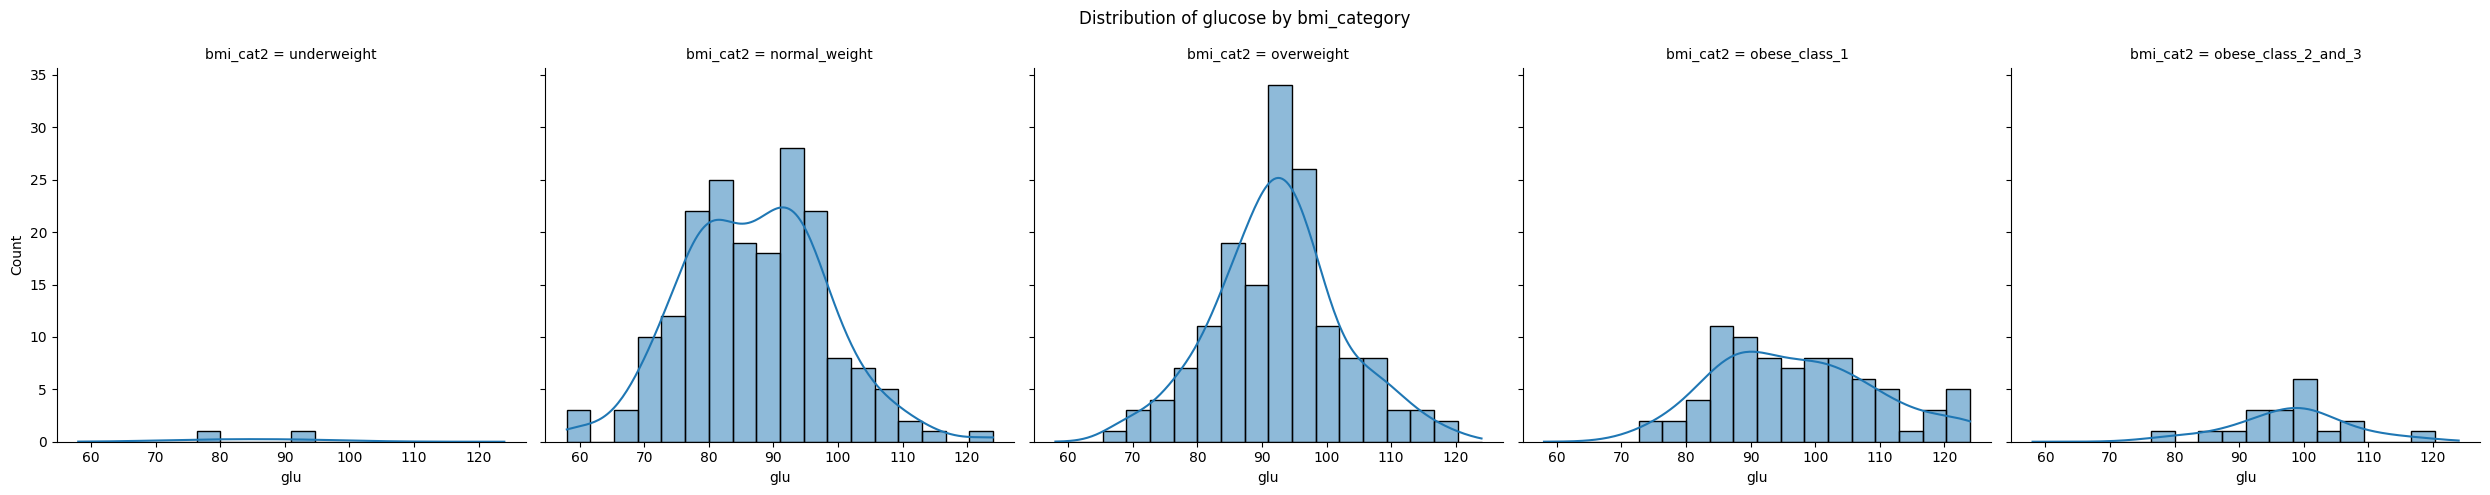

g_underweight underweight
ShapiroResult(statistic=np.float64(nan), pvalue=np.float64(nan))
g_normal_weight normal_weight
ShapiroResult(statistic=np.float64(0.9936064746358401), pvalue=np.float64(0.5998423573636585))
g_overweight overweight
ShapiroResult(statistic=np.float64(0.9893194706586345), pvalue=np.float64(0.28863074023394153))
g_obese_class_1 obese_class_1
ShapiroResult(statistic=np.float64(0.9699680545968379), pvalue=np.float64(0.05648370204012818))
g_obese_class_2_and_3 obese_class_2_and_3
ShapiroResult(statistic=np.float64(0.9713233366699989), pvalue=np.float64(0.802590793853175))


In [84]:
# Test the normality within each group
variable = 'glu'
sns.displot(data=df, x= variable, col='bmi_cat2', kde=True)
plt.suptitle("Distribution of glucose by bmi_category")
plt.tight_layout()
plt.show()

# Shapiro test 
group_list = [] 
group_value = df['bmi_cat2'].cat.categories.tolist()
for i in group_value: 
    g = "g_"+i
    print(g, i)
    print(shapiro(df[df['bmi_cat2'] == str(i)][variable]))

- For all groups the p_value of the Shapiro test > 0.05, so we consider that the 'glucose' variable is normally distributed by group

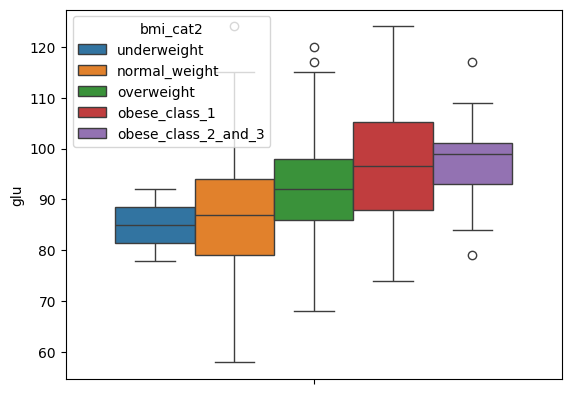

In [85]:
sns.boxplot(data=df, y='glu', hue='bmi_cat2')
plt.show()

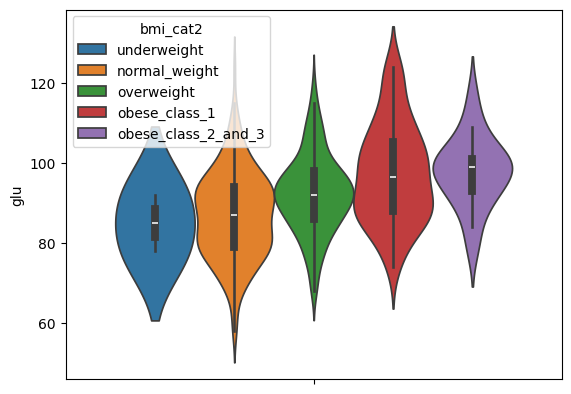

Index(['underweight', 'normal_weight', 'overweight', 'obese_class_1',
       'obese_class_2_and_3'],
      dtype='object')


LeveneResult(statistic=np.float64(2.94469501745772), pvalue=np.float64(0.020158542767228414))

In [86]:
# ** Variances Levene Test + graph
variable = 'glu'
var_group = 'bmi_cat2'

# Plot boxplot 
sns.violinplot(data=df, y=variable, hue=var_group)
plt.show()

# test de variances
group_list = []
print(df[var_group].cat.categories)
for cat in df[var_group].cat.categories: 
    group = df[df[var_group] == cat][variable]
    group_list.append(group)
levene(*group_list)

- p < 0.05, so we failed to reject the null hypothesis, which implies all input samples are from populations with equal variances

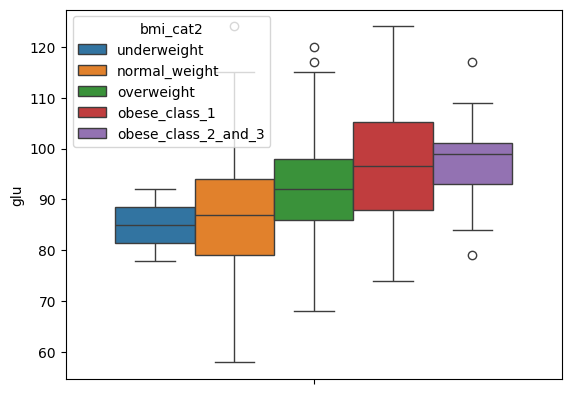

              bmi_cat2  mean   std
0          underweight  85.0   9.9
1        normal_weight  87.0  11.0
2           overweight  92.4   9.8
3        obese_class_1  97.4  12.4
4  obese_class_2_and_3  98.0   8.8


In [87]:
# EDA for anova
variable = 'glu'
var_group = 'bmi_cat2'

# Plot boxplot 
sns.boxplot(data=df, y=variable, hue=var_group)
plt.show()

# Computation of the mean and standard deviation by group
std_by_groupe = pd.DataFrame(df.groupby(var_group)[variable].agg(['mean','std'])).reset_index().round(1)
print(std_by_groupe)


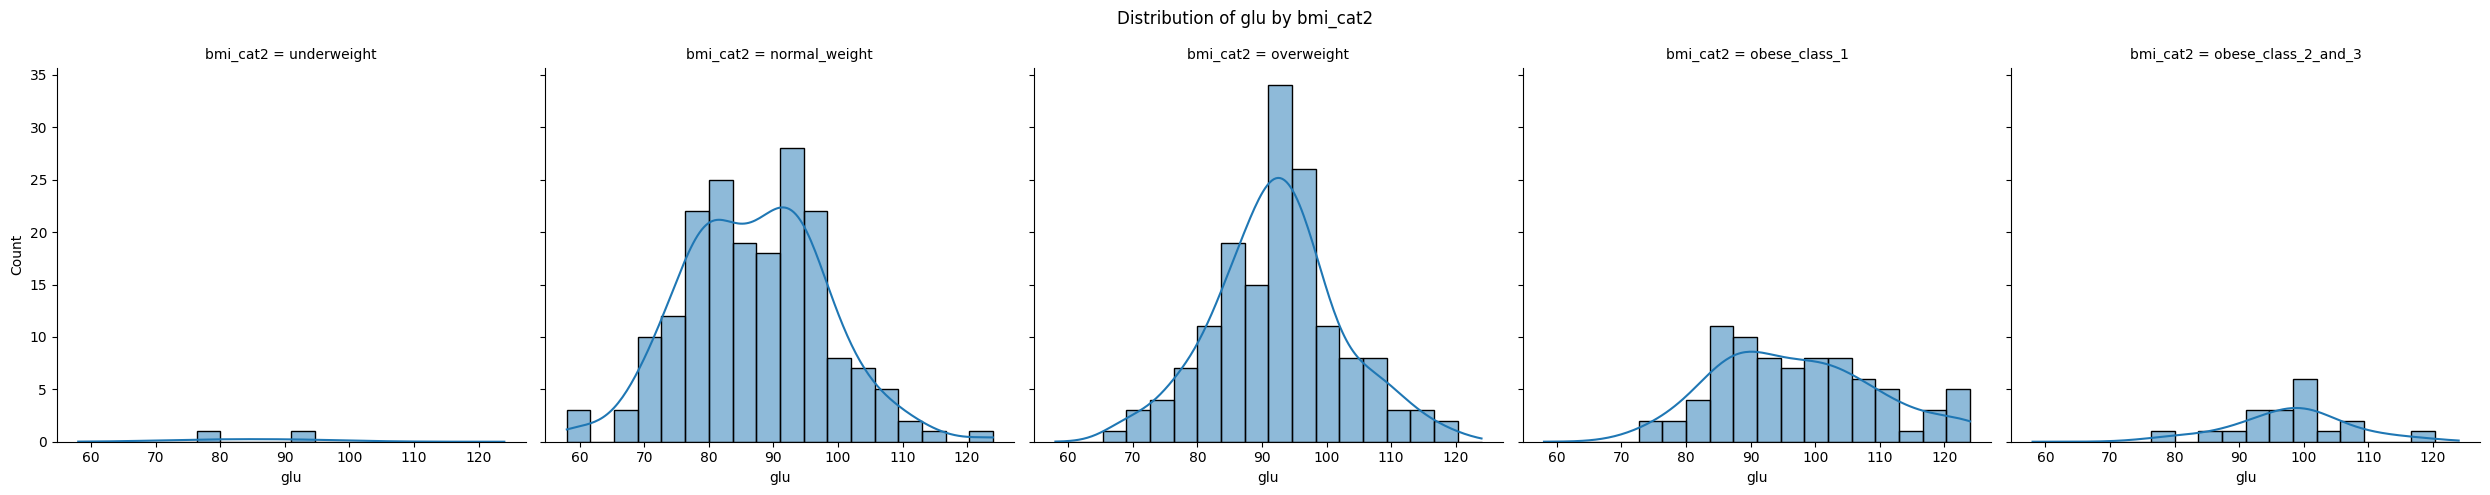

** Shapiro Test**

                groups  statistic  p value
0          underweight        NaN      NaN
1        normal_weight     0.9936   0.5998
2           overweight     0.9893   0.2886
3        obese_class_1     0.9700   0.0565
4  obese_class_2_and_3     0.9713   0.8026 

For at least one group the p_value < alpha = 0.01, so we reject the null hypothesis and the glu distribution is not normal within the groups

** Test equality of variance - Levene test**

p_value > alpha = 0.01, so fail to reject the null hypothesis and the variances of glu within a group are equals


LeveneResult(statistic=np.float64(2.94469501745772), pvalue=np.float64(0.020158542767228414))

In [88]:
# Check hypothesis 
from stats_utils import check_normality_by_group, check_levene_by_group
variable = 'glu'
check_normality_by_group(df, variable, 'bmi_cat2')
check_levene_by_group(df, variable, 'bmi_cat2', alpha=0.01)

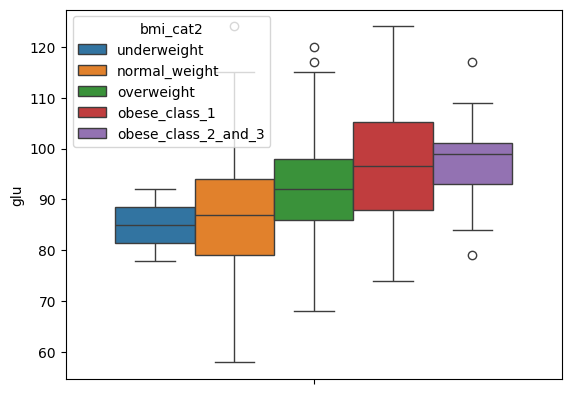

,bmi_cat2,mean,std
0,underweight,85.0,9.9
1,normal_weight,87.0,11.0
2,overweight,92.4,9.8
3,obese_class_1,97.4,12.4
4,obese_class_2_and_3,98.0,8.8


In [89]:
# Analysis before anova
from stats_utils import eda_for_anova
eda_for_anova(df, variable, var_group)

In [90]:
# Anova
alpha = 0.05
pingouin.anova(data=df, dv=variable, between=var_group)

,Source,ddof1,ddof2,F,p-unc,np2
0,bmi_cat2,4,437,16.131604,2.483539e-12,0.12866


In [91]:
f_oneway(*group_list)

F_onewayResult(statistic=np.float64(16.131604284600154), pvalue=np.float64(2.4835392689372097e-12))

- the p_value < 0.05 so we reject the null hypothesis, and therefore we consider that there is a significant difference in the cholesterol level by group

In [92]:
# Let's determine which groups have significant differences.
post_hocs = pingouin.pairwise_tests(dv=variable, between=var_group, data=df, padjust = 'bonf')
post_hocs.round(4)

,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,bmi_cat2,underweight,normal_weight,False,True,-0.2899,1.0267,two-sided,0.8194,1.0000,bonf,0.536,-0.1853
1,bmi_cat2,underweight,overweight,False,True,-1.0486,1.0256,two-sided,0.4814,1.0000,bonf,0.706,-0.7473
2,bmi_cat2,underweight,obese_class_1,False,True,-1.7432,1.0793,two-sided,0.3176,1.0000,bonf,1.23,-0.9998
3,bmi_cat2,underweight,obese_class_2_and_3,False,True,-1.7843,1.1731,two-sided,0.2963,1.0000,bonf,1.242,-1.4074
4,bmi_cat2,normal_weight,overweight,False,True,-4.7357,337.2450,two-sided,0.0000,0.0000,bonf,4320.98,-0.5087
5,bmi_cat2,normal_weight,obese_class_1,False,True,-6.5015,135.2543,two-sided,0.0000,0.0000,bonf,2.155e+07,-0.9081
6,bmi_cat2,normal_weight,obese_class_2_and_3,False,True,-5.0374,24.1218,two-sided,0.0000,0.0004,bonf,1.208e+04,-1.0096
7,bmi_cat2,overweight,obese_class_1,False,True,-3.1744,131.9358,two-sided,0.0019,0.0187,bonf,15.932,-0.4681
8,bmi_cat2,overweight,obese_class_2_and_3,False,True,-2.5874,23.8613,two-sided,0.0162,0.1620,bonf,4.307,-0.5741
9,bmi_cat2,obese_class_1,obese_class_2_and_3,False,True,-0.2299,36.9109,two-sided,0.8195,1.0000,bonf,0.266,-0.0474


- There is a significant difference in almost all group tuples, except between:
- overweight & obese_class_2_and_3: p_value > 0.05
- obese_class_1 & obese_class_2_and_3: p_value > 0.05
The first case is strange; this must surely be due to the small sample size in the obese_class_2_and_3 group, compared to overweight.

##### Conclusion
**Test used** : Anova  
**Interpretation** :    
There **is a significant differences** of the glucose level between the bmi classes.

#### **5. Is there a difference between the different BMI classes in relation to the progression 'y'?** 

##### Test
- $ \{ H_0 $: There is **no significant difference** between the individual group means.
- $ \{ H_1 $: There is a **significant difference**.

**Choice of test**: Kruskal Wallis (non-parametric test)
- $ \alpha $ = 0.05

**Hypotheses to be verified**:
- The BMI categories are independent.
- The progression, y, is a numeric variable.
- The variable 'y' is not approximately normal.
- Check whether the variances in each group are approximately equal.

In [93]:
# Parameters: 
alpha = 0.01
variable = 'y'
var_group = 'bmi_cat2'
group_list = []
print(df[var_group].cat.categories)
for cat in df[var_group].cat.categories: 
    group = df[df[var_group] == cat][variable]
    group_list.append(group)

Index(['underweight', 'normal_weight', 'overweight', 'obese_class_1',
       'obese_class_2_and_3'],
      dtype='object')


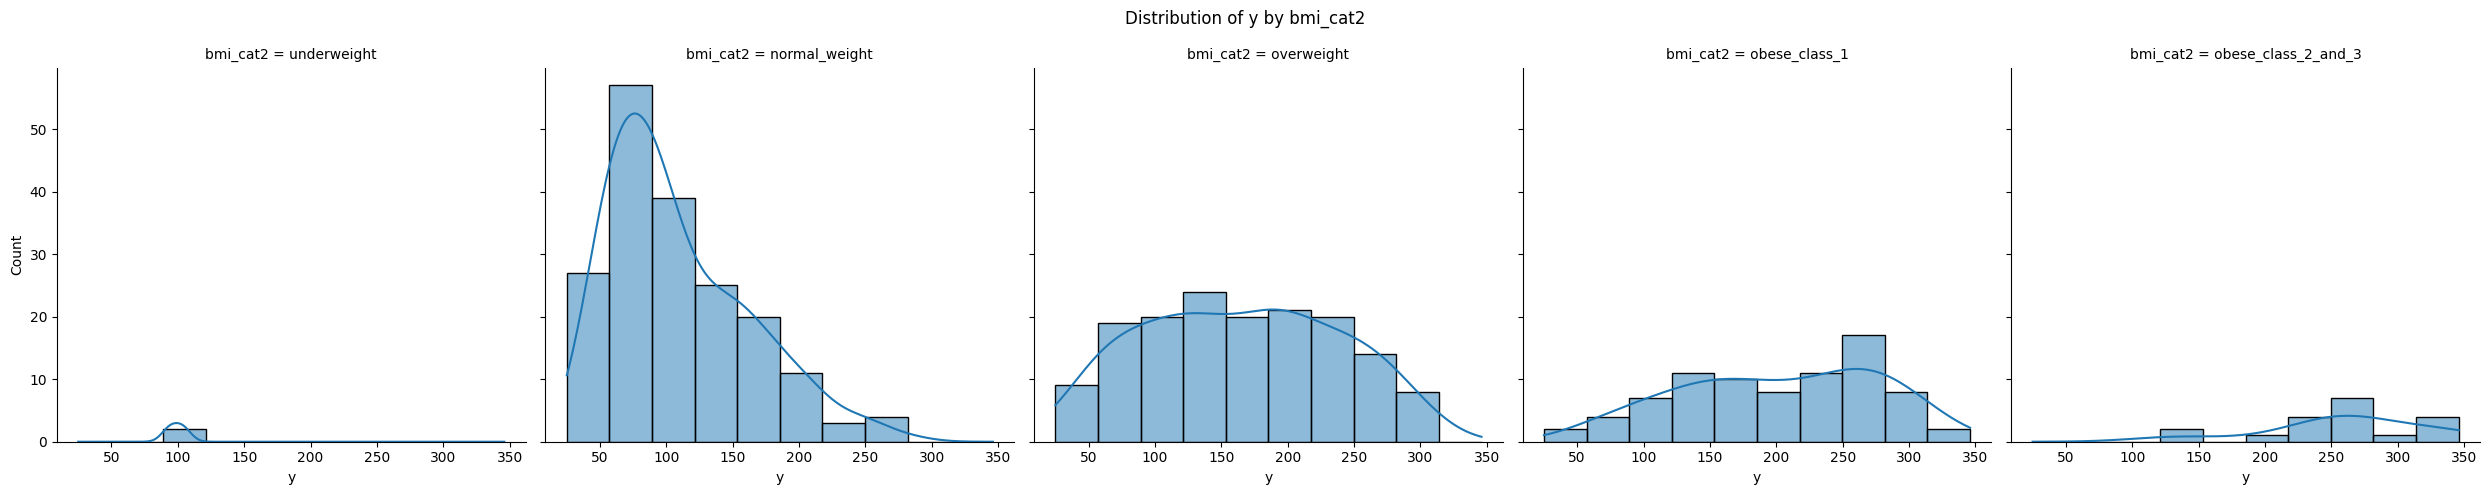

** Shapiro Test**

                groups  statistic  p value
0          underweight        NaN      NaN
1        normal_weight     0.9204   0.0000
2           overweight     0.9706   0.0021
3        obese_class_1     0.9627   0.0196
4  obese_class_2_and_3     0.9272   0.1537 

For at least one group the p_value < alpha = 0.01, so we reject the null hypothesis and the y distribution is not normal within the groups

** Test equality of variance - Levene test**

p_value < alpha = 0.01, so we reject the null hypothesis and the variances of y within the groups are not equals


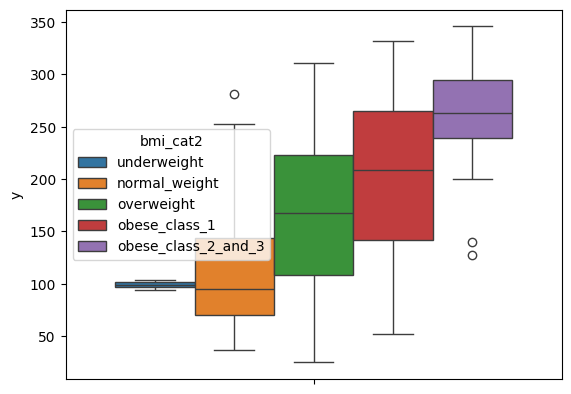

,bmi_cat2,mean,std
0,underweight,99.0,7.1
1,normal_weight,109.4,52.8
2,overweight,165.0,73.0
3,obese_class_1,202.1,73.5
4,obese_class_2_and_3,260.8,59.6


In [94]:
# Check hypothesis 
from stats_utils import check_normality_by_group, check_levene_by_group
check_normality_by_group(df, variable, var_group)
check_levene_by_group(df, variable, var_group, alpha=0.01)

# EDA 
eda_for_anova(df, variable, var_group)

In [95]:
pingouin.kruskal(data=df, dv=variable, between=var_group)

,Source,ddof1,H,p-unc
Kruskal,bmi_cat2,4,123.728855,8.531502e-26


In [96]:
print(len(group_list))
stats.kruskal(*group_list)

5


KruskalResult(statistic=np.float64(123.72885493602116), pvalue=np.float64(8.531501847309203e-26))

- p_value < alpha, so we reject the null hypothesis, and there is a significant differences of progression between the groups

##### Conclusion
**Test used** : Kruskal Wallis  
**Interpretation** :    
There **is a significant differences** of the progression 'y' between the bmi classes. That mean, this variable quand be usefull to predict the progression, in the modelisation part

#### 6. Is there a significant difference in obesity between men and women?

**Objective**: To test whether there is a significant difference of the proportion of obese between the man and woman.

- $ \{ H_0 $ : There is **no difference** of obesity between men and women.
- $ \{ H_1 $ : There is a **significant difference**.

**Choice of test**: chi2  
- $ \alpha $ = 0.05

**Hypotheses to check when performing a chi2** :
- Male/female groups are independent. 
- random sample

In [97]:
# 1. Flag obesity 
df['is_obese'] = df['bmi'].apply(lambda x: 1 if x > 30 else 0)

sex  is_obese
0    0           0.782979
     1           0.217021
1    0           0.787440
     1           0.212560
Name: proportion, dtype: float64


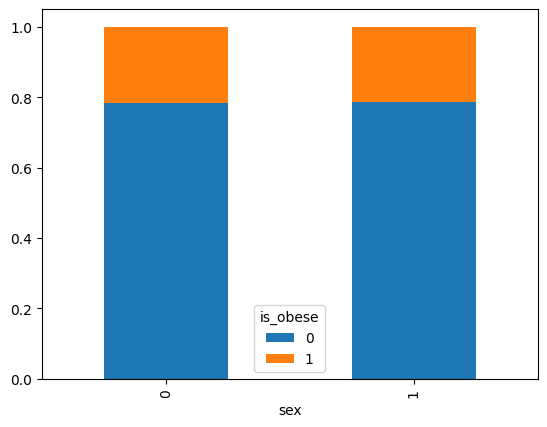

In [98]:
# 2. EDA before testing 
# Proportion of obese by gender 
props = df.groupby('sex')['is_obese'].value_counts(normalize = True)
print(props)

# Convert props to wide format
wide_props = props.unstack()

# plot the stacked barplot
wide_props.plot(kind='bar', stacked=True)
plt.show()

- At first glance, there doesn't seem to be a big difference in obesity between men and women.
- Let's check what the test says.

In [99]:
# 3. Perform chi2 Test 
contengency_table = pd.crosstab(df['sex'], df['is_obese'])
chi2, p, dof, expected = chi2_contingency(contengency_table)
print(f"Chi2: {chi2:.2f}, p-value: {p:.4f}")
if p < 0.05: 
    print("We reject HO: the variables are dependant")
else: 
    print("We failed to reject H0: no relation found")

Chi2: 0.00, p-value: 1.0000
We failed to reject H0: no relation found


##### Conclusion
**Test used**: Chi-squared test of independence

**Result**:  
Chi2 = 0.00 | p-value = 1.0000

**Interpretation**:  
We fail to reject the null hypothesis (H₀).  
There is **no statistically significant difference** in the proportion of obese individuals between men and women in this diabetic population.

This result supports what the exploratory analysis showed:  
the obesity rates are nearly identical across gender (approximately 21.2% in men vs 21.7% in women).  

### Conclusion for the statistical Test part
In this section, several statistical tests were performed to better understand the significant differences between groups and the relationships between the quantitative and qualitative variables in the dataset, with the aim of addressing the medical team's concerns.  

- Gender influences glucose, but not progression.
- There is no obesity prevalence (BMI > 30) between the man and woman
- BMI classes influence both glucose and progression, which justifies their use in predictive models.
- The choice between parametric and non-parametric tests was guided by normality and homogeneity of variances.
- These checks ensured the validity of the statistical tests.

From these statistical tests, we identified variables significantly associated with the disease progression and glucose levels, such as BMI class and glucose level.  
On the contrary, some variables like gender appear to have no direct impact on disease progression.

These insights will now guide the **feature selection and modelling choices** in the next section.

# Export Cleaned Data

In [100]:
# Enregistrer le dataframe pour le prochain notebook
df.to_pickle("../data/processed/df_diabetes_processed.pkl")

In [101]:
# import pickle
column_long_name

{'age': 'age',
 'sex': 'sex',
 'bmi': 'body_mass_index',
 'bp': 'average_blood_pressure',
 'tc': 'total_cholesterol',
 'ldl': 'low_density_lipoproteins',
 'hdl': 'high_density_lipoproteins',
 'tch': 'total_cholesterol/HDL',
 'ltg': 'log_of_triglycerides_level',
 'glu': 'glucose',
 'y': 'progression_y'}

In [102]:
import os
import pickle

# Définir le chemin du fichier
file_path = "../data/processed/processed_data_and_desc.pkl"

# Si le fichier existe déjà, on le supprime
if os.path.exists(file_path):
    os.remove(file_path)
    print(f"Fichier existant supprimé : {file_path}")

# Créer et sauvegarder à nouveau
with open(file_path, "wb") as f:
    pickle.dump({'df_diabetes_processed': df, 'col_desc': column_long_name}, f)
    print(f"Nouveau fichier sauvegardé : {file_path}")

Fichier existant supprimé : ../data/processed/processed_data_and_desc.pkl
Nouveau fichier sauvegardé : ../data/processed/processed_data_and_desc.pkl
